<a href="https://colab.research.google.com/github/Cumberkid/Learning-the-Optimal-Solution-Path/blob/main/Fair_Regression_Learning_the_Optimal_Solution_Path_vs_Naive_Grid_Search_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the necessary libraries

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader  #for creating the dataset


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import pandas as pd

In [4]:
import importlib

Uncomment the !wget line if using Colab instead of Jupyter

In [5]:
!wget -O helpers.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/helpers.py

import helpers

importlib.reload(helpers)

--2024-01-27 01:45:21--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2345 (2.3K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]   2.29K  --.-KB/s    in 0s      

2024-01-27 01:45:21 (33.4 MB/s) - ‘helpers.py’ saved [2345/2345]



<module 'helpers' from '/content/helpers.py'>

In [6]:
!wget -O NGS.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS.py

import NGS

importlib.reload(NGS)

--2024-01-27 01:45:21--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13998 (14K) [text/plain]
Saving to: ‘NGS.py’

NGS.py              100%[===================>]  13.67K  --.-KB/s    in 0.001s  

2024-01-27 01:45:21 (18.9 MB/s) - ‘NGS.py’ saved [13998/13998]

Using device: cpu
Using device: cpu


<module 'NGS' from '/content/NGS.py'>

In [7]:
!wget -O SGD.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD.py

import SGD

importlib.reload(SGD)

--2024-01-27 01:45:21--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10059 (9.8K) [text/plain]
Saving to: ‘SGD.py’

SGD.py              100%[===================>]   9.82K  --.-KB/s    in 0s      

2024-01-27 01:45:21 (66.5 MB/s) - ‘SGD.py’ saved [10059/10059]

Using device: cpu
Using device: cpu


<module 'SGD' from '/content/SGD.py'>

# Preliminaries

## Synthetic Dataset

In [ ]:
#some synthetic data for instance below
np.random.seed(8675309)
torch.manual_seed(8675309) #Ensures linear layer initializes deterministically for reproducibility

X, y = helpers.gen_data(100, 100, 2)

# beta_star = torch.from_numpy(beta_star) #useful to store as tensor for later

In [ ]:
#The pytorch built-in binary cross-entropy loss
criterion = torch.nn.BCELoss()

input_dim = X.shape[1]

## Wisconsin Breast Cancer Dataset
We use the Wisconsin breast cancer dataset and then port it over an object of the Pytorch dataset class so it can be read by data_loader.

Description of the breast cancer Wisconsin dataset (classification): https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
# load breast cancer data
X, y = load_breast_cancer(return_X_y=True)

In [ ]:
import pandas as pd

df = pd.DataFrame(X).describe()

df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression(solver='lbfgs', max_iter=100).fit(X[:100,:], y[:100])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
clf.predict(X[:100,:])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0])

In [ ]:
# preprocess data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
df = pd.DataFrame(X).describe()

df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-3.153111e-15,-6.568462e-15,-6.993039e-16,-8.553985e-16,6.081447e-15,-1.136369e-15,-2.997017e-16,1.023981e-15,-1.860648e-15,-1.504752e-15,...,-2.297713e-15,1.742016e-15,-1.198807e-15,6.118909e-16,-5.094929e-15,-2.122887e-15,6.118909e-16,-1.998011e-16,-2.422589e-15,2.497514e-15
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-1.726901e+00,-2.223994e+00,-1.693361e+00,-1.222423e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-6.749213e-01,-7.486293e-01,-6.895783e-01,-6.421359e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-2.690395e-01,-4.351564e-02,-2.859802e-01,-3.411812e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,5.220158e-01,6.583411e-01,5.402790e-01,3.575891e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,4.094189e+00,3.885905e+00,4.287337e+00,5.930172e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


## Law School Admission Bar Passage Dataset
We use the Law School Admission Bar Passage dataset originally collected for a study called 'LSAC National Longitudinal Bar Passage Study' by Linda Wightman in 1998 and then port it over an object of the Pytorch dataset class so it can be read by data_loader.

Description of the dataset (classification): https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

In [8]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/bar_pass_prediction.csv'
df = pd.read_csv(csv_file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22407 entries, 0 to 22406
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   decile1b                 20803 non-null  float64
 1   decile3                  20803 non-null  float64
 2   ID                       22407 non-null  int64  
 3   decile1                  21315 non-null  float64
 4   sex                      22402 non-null  float64
 5   race                     22391 non-null  float64
 6   cluster                  22311 non-null  float64
 7   lsat                     22407 non-null  float64
 8   ugpa                     22407 non-null  float64
 9   zfygpa                   21423 non-null  float64
 10  DOB_yr                   22357 non-null  float64
 11  grad                     22404 non-null  object 
 12  zgpa                     21118 non-null  float64
 13  bar1                     22407 non-null  object 
 14  bar1_yr               

In [9]:
print("Feature Names:", "', '".join(df.columns))

Feature Names: decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster', 'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr', 'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime', 'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp', 'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp', 'indxgrp2', 'dnn_bar_pass_prediction', 'gpa


In [10]:
df = df.dropna()
len(df)

20427

In [11]:
from sklearn.preprocessing import OneHotEncoder

# Assuming 'categorical_column' is a column that you want to one-hot encode
# Replace 'categorical_column' with the actual name of the categorical column
categorical_column = ['grad', 'gender', 'race1', 'race2', 'Dropout', 'indxgrp', 'indxgrp2']

# Create a DataFrame with the categorical column
categorical_df = df[categorical_column]

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the categorical column
one_hot_encoded = encoder.fit_transform(categorical_df)

# Convert the one-hot encoded result to a DataFrame
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_column))


# Concatenate the one-hot encoded DataFrame with the original DataFrame, dropping the original categorical column
df_encoded = pd.concat([df.drop(columns=categorical_column), one_hot_encoded_df], axis=1)

df_encoded = df_encoded.dropna()


In [12]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18668 entries, 0 to 20426
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   decile1b                 18668 non-null  float64
 1   decile3                  18668 non-null  float64
 2   ID                       18668 non-null  float64
 3   decile1                  18668 non-null  float64
 4   sex                      18668 non-null  float64
 5   race                     18668 non-null  float64
 6   cluster                  18668 non-null  float64
 7   lsat                     18668 non-null  float64
 8   ugpa                     18668 non-null  float64
 9   zfygpa                   18668 non-null  float64
 10  DOB_yr                   18668 non-null  float64
 11  zgpa                     18668 non-null  float64
 12  bar1                     18668 non-null  object 
 13  bar1_yr                  18668 non-null  float64
 14  bar2                  

In [13]:
print("Feature Names:", "', '".join(df_encoded.columns))

Feature Names: decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster', 'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'zgpa', 'bar1', 'bar1_yr', 'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'parttime', 'male', 'other', 'asian', 'black', 'hisp', 'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'dnn_bar_pass_prediction', 'gpa', 'gender_male', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'race2_b white', 'race2_c other', 'indxgrp_b 400-460', 'indxgrp_c 460-520', 'indxgrp_d 520-580', 'indxgrp_e 580-640', 'indxgrp_f 640-700', 'indxgrp_g 700+', 'indxgrp2_b 400-460', 'indxgrp2_c 460-520', 'indxgrp2_d 520-580', 'indxgrp2_e 580-640', 'indxgrp2_f 640-700', 'indxgrp2_g 700-760', 'indxgrp2_h 760-820', 'indxgrp2_i 820+


In [14]:
# Choose the features to be used
cols = ['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster', 'lsat',
        'ugpa', 'zfygpa', 'DOB_yr', 'zgpa', 'fulltime', 'fam_inc', 'age', 'parttime',
        'male', 'other', 'asian', 'black', 'hisp', 'tier', 'index6040', 'gpa',
        'gender_male', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white',
        'race2_b white', 'race2_c other', 'indxgrp_b 400-460', 'indxgrp_c 460-520',
        'indxgrp_d 520-580', 'indxgrp_e 580-640', 'indxgrp_f 640-700', 'indxgrp_g 700+',
        'indxgrp2_b 400-460', 'indxgrp2_c 460-520', 'indxgrp2_d 520-580', 'indxgrp2_e 580-640',
        'indxgrp2_f 640-700', 'indxgrp2_g 700-760', 'indxgrp2_h 760-820', 'indxgrp2_i 820+']

In [15]:
X = df_encoded[cols]
y = df_encoded['pass_bar']

In [16]:
sp = df_encoded.sample(n=1000, random_state=2024)

In [17]:
sp_white = sp[sp['race'] == 7]
sp_other = sp[sp['race'] != 7]

len(sp_white), len(sp_other)

(856, 144)

In [18]:
passed = sp[sp['pass_bar'] == 1]
len(passed)

956

In [19]:
X_sp = sp[cols]
y_sp = sp['pass_bar']

In [20]:
pd.DataFrame(X_sp).describe()

,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,indxgrp_f 640-700,indxgrp_g 700+,indxgrp2_b 400-460,indxgrp2_c 460-520,indxgrp2_d 520-580,indxgrp2_e 580-640,indxgrp2_f 640-700,indxgrp2_g 700-760,indxgrp2_h 760-820,indxgrp2_i 820+
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.563000,5.562000,13798.149000,5.743000,1.578000,6.559000,2.769000,37.004300,3.243100,0.085120,...,0.171000,0.673000,0.003000,0.022000,0.032000,0.097000,0.171000,0.227000,0.226000,0.220000
std,2.848182,2.835171,7996.022171,2.790831,0.494126,1.301619,1.345157,5.349013,0.355976,0.933104,...,0.376697,0.469352,0.054717,0.146757,0.176088,0.296106,0.376697,0.419102,0.418448,0.414454
min,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,18.000000,2.200000,-2.550000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,6802.000000,3.000000,1.000000,7.000000,1.000000,34.000000,3.000000,-0.540000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,6.000000,14149.500000,6.000000,2.000000,7.000000,3.000000,37.000000,3.300000,0.105000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,8.000000,20442.500000,8.000000,2.000000,7.000000,4.000000,41.000000,3.500000,0.730000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,10.000000,27447.000000,10.000000,2.000000,8.000000,6.000000,48.000000,3.900000,2.760000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# preprocess data
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
scaler = RobustScaler()
scaler.fit(X_sp)
X_sp = scaler.transform(X_sp)

pd.DataFrame(X_sp).describe()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.087400,-0.087600,-0.025758,-0.051400,-0.422000,-0.441000,-0.077000,0.000614,-0.113800,-1.565354e-02,...,0.171000,-0.327000,0.003000,0.022000,0.032000,0.097000,0.171000,0.227000,0.226000,0.220000
std,0.569636,0.567034,0.586197,0.558166,0.494126,1.301619,0.448386,0.764145,0.711953,7.347278e-01,...,0.376697,0.469352,0.054717,0.146757,0.176088,0.296106,0.376697,0.419102,0.418448,0.414454
min,-1.000000,-1.000000,-1.037169,-1.000000,-1.000000,-6.000000,-0.666667,-2.714286,-2.200000,-2.090551e+00,...,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.600000,-0.600000,-0.538653,-0.600000,-1.000000,0.000000,-0.666667,-0.428571,-0.600000,-5.078740e-01,...,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.071532e-18,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.400000,0.400000,0.461347,0.400000,0.000000,0.000000,0.333333,0.571429,0.400000,4.921260e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.800000,0.800000,0.974854,0.800000,0.000000,1.000000,1.000000,1.571429,1.200000,2.090551e+00,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [23]:
clf = LogisticRegression(solver='lbfgs', max_iter=100).fit(X_sp, y_sp)

In [24]:
accuracy_score(y_sp, clf.predict(X_sp))

0.96

In [25]:
from sklearn.metrics import confusion_matrix

# ?confusion_matrix

In [26]:
cm = confusion_matrix(y_sp, clf.predict(X_sp))
cm

array([[  6,  38],
       [  2, 954]])

In [27]:
TPR =  cm.ravel()[3] / (cm.ravel()[3] + cm.ravel()[2] )                               #TPR = TP / P = TP / (TP + FN)
print('TPR is: %.4f' % TPR)

FPR = cm.ravel()[1] / (cm.ravel()[1] + cm.ravel()[0] )                         #FPR = FP / N = FP / (FP + TN)
print('FPR is: %.4f' % FPR)

TPR is: 0.9979
FPR is: 0.8636


In [28]:
X = np.array(X_sp)
y = np.array(y_sp)

## Tuning the Learning Rate for Naive Grid Search

To gauge the performance of our model, we set up a benchmark with Naive Grid Search.

This method discretize the path over $\lambda \in [0,1]$ into a number of grids and trains a linear model on each grid.

Use the first 100 datapoints to select the best constant learning rate for Naive Grid Search. Make several plots of sup error along the solution path against learning rate using 500 iterations.

In [ ]:
lr_list = 0.5 ** torch.arange(-2, 9)
alpha_list = 0.5 ** torch.arange(-3, 8)
epochs = 500
input_dim = X.shape[1]
lam = 0.5
init_weight = torch.zeros(input_dim)
init_intercept = 0
criterion = torch.nn.BCELoss()

In [ ]:
X_tune = X[:200, :]
y_tune = y[:200]

In [ ]:
# X_major = X_tune[y_tune == 1]
# y_major = np.ones(len(X_major))
# X_minor = X_tune[y_tune == 0]
# y_minor = np.zeros(len(X_minor))
# lam = len(X_minor) / len(X_tune)
# lam

In [ ]:
# tune learning rate on the first 100 datapoints
tune_data = helpers.Regression_Data(X_tune, y_tune)
# tune_data = helpers.Regression_Data(X, y)
# full gradient descent uses all data points
tune_GD_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
tune_SGD_data_loader = DataLoader(tune_data, batch_size=20, shuffle=True, )
# test data do not shuffle
tune_test_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=False, )

###First, we tune full gradient descent.
For full gradient descent we use constant learning rate. We shall tune the learning rate directly.

In [ ]:
losses = []
for lr in lr_list:
    # train a model
    model = NGS.Logistic_Regression(input_dim, 1, lam, init_weight, init_intercept).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        NGS.fair_train(tune_GD_data_loader, model, criterion, optimizer)

    loss = NGS.fair_test(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 4.0	 loss: 0.0078284265473485
learning rate: 2.0	 loss: 0.014462154358625412
learning rate: 1.0	 loss: 0.024338925257325172
learning rate: 0.5	 loss: 0.036610983312129974
learning rate: 0.25	 loss: 0.05307164043188095
learning rate: 0.125	 loss: 0.07778024673461914
learning rate: 0.0625	 loss: 0.11547258496284485
learning rate: 0.03125	 loss: 0.17115333676338196
learning rate: 0.015625	 loss: 0.2465953528881073
learning rate: 0.0078125	 loss: 0.3341495990753174
learning rate: 0.00390625	 loss: 0.4172912836074829


From the plot, we see that learning rate = $2$ gives a low loss stably.

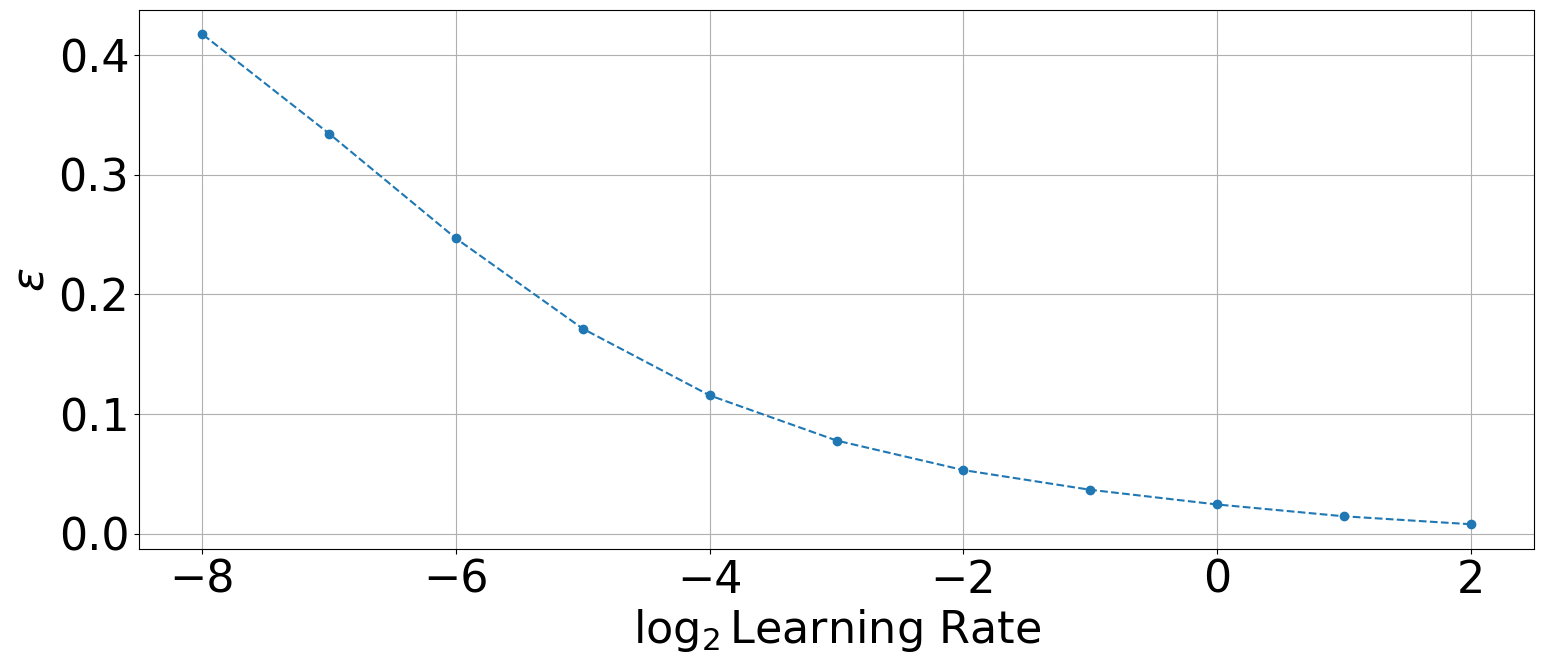

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list), torch.tensor(losses), '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)

###Next, we tune stochastic gradient descent.

For stochastic gradient descent, we are using shrinking learning rate $\frac{\alpha}{T}$ for iteration $T$. We shall tune $\alpha$.

In [ ]:
losses = []
for alpha in alpha_list:
    # train a model
    model = NGS.Logistic_Regression(input_dim, 1, lam, init_weight, init_intercept).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([1, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        NGS.fair_train(tune_SGD_data_loader, model, criterion, optimizer, trace_frequency=5)

    loss = NGS.fair_test(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 8.0	 loss: 0.046848949044942856
alpha: 4.0	 loss: 0.06304726749658585
alpha: 2.0	 loss: 0.08034971356391907
alpha: 1.0	 loss: 0.10893718898296356
alpha: 0.5	 loss: 0.20565873384475708
alpha: 0.25	 loss: 0.30776363611221313
alpha: 0.125	 loss: 0.423923134803772
alpha: 0.0625	 loss: 0.49944716691970825
alpha: 0.03125	 loss: 0.5370672345161438
alpha: 0.015625	 loss: 0.5703651905059814
alpha: 0.0078125	 loss: 0.6044848561286926


From the plot, we see that $\alpha = 2^3$ gives a low loss stably.

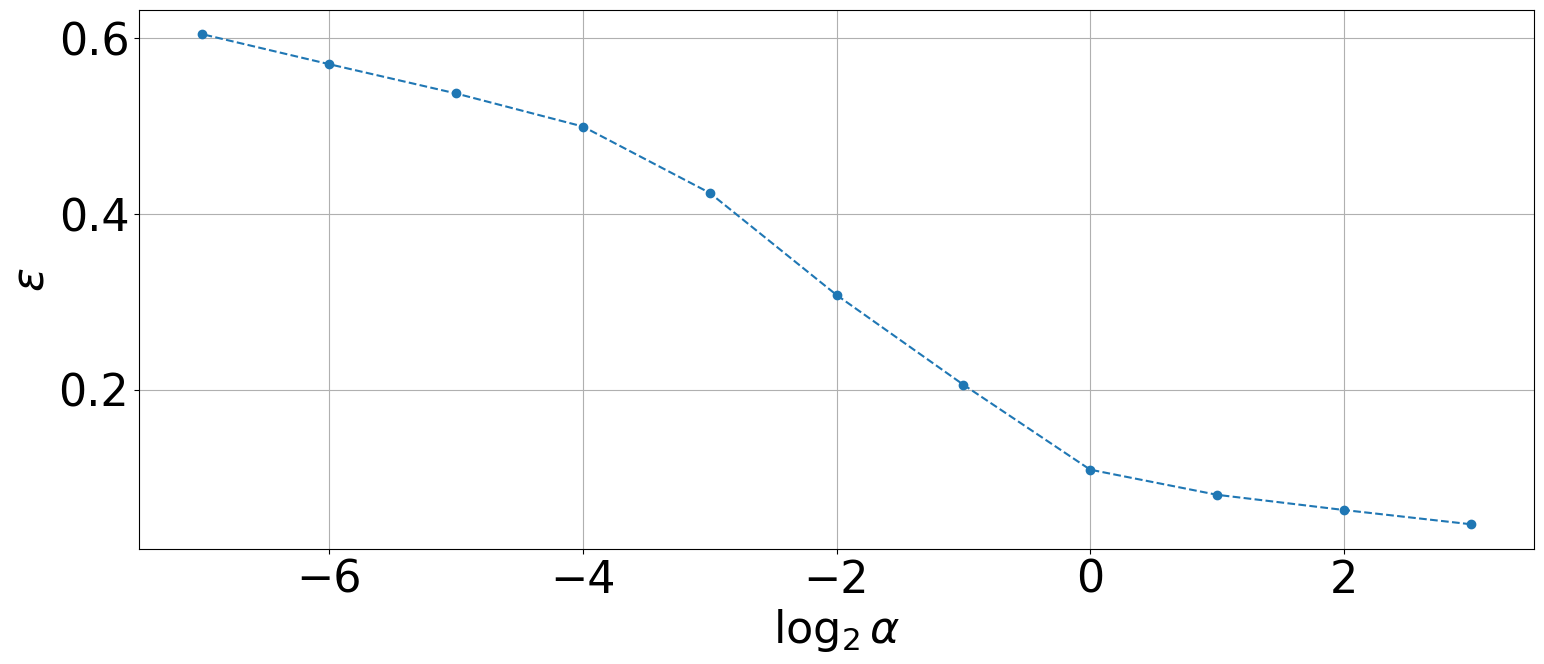

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), losses, '--o')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

## The True Solution Path

We use the Naive Grid Search with $2^{10}$ grids, trained by full gradient descent with learning rate = $2^{-4}$ and 5000 iterations on each grid, to generate a true solution path.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
full_data = helpers.Regression_Data(X, y)
# full gradient descent uses all data points
GD_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(full_data, batch_size=5, shuffle=True, )
# test data
test_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=False, )

In [ ]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]
criterion=torch.nn.BCELoss()

In [ ]:
num_grid = 2**10
lambdas = np.linspace(lam_max, lam_min, num_grid)
fine_delta_lam = (lam_max - lam_min)/(num_grid - 1)

In [ ]:
epochs = 5000
lr = 2

In [ ]:
total_itr, reg_params, intercepts, weights = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=epochs, loss_fn=criterion,
                                trainDataLoader=GD_data_loader,
                                data_input_dim=input_dim, obj='fairness',
                                lr=lr, SGD=False)

In [ ]:
losses = NGS.get_losses(lam_min, lam_max, fine_delta_lam, intercepts,
                              weights, reg_params, test_data_loader, criterion)

In [ ]:
thetas = np.array(weights)
print(thetas.shape)

In [ ]:
import csv

csv_file_path = '/content/drive/MyDrive/Experiments/exact_soln_list.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    # Create a CSV writer
    csv_writer = csv.writer(csv_file)

    # Write the headers
    csv_writer.writerow(['losses', 'theta_0', 'theta_1', 'theta_2', 'theta_3',
                         'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8',
                         'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13',
                         'theta_14', 'theta_15', 'theta_16', 'theta_17', 'theta_18',
                         'theta_19', 'theta_20', 'theta_21', 'theta_22', 'theta_23',
                         'theta_24', 'theta_25', 'theta_26', 'theta_27', 'theta_28',
                         'theta_29', 'theta_30', 'theta_31', 'theta_32', 'theta_33',
                         'theta_34', 'theta_35', 'theta_36', 'theta_37', 'theta_38',
                         'theta_39', 'theta_40', 'theta_41', 'theta_42', 'theta_43',
                         'theta_44', 'theta_45'])

    # Write the data from your lists
    for i in range(num_grid):
        csv_writer.writerow([losses[i], intercepts[i], thetas[i][0], thetas[i][1],
                             thetas[i][2], thetas[i][3], thetas[i][4], thetas[i][5],
                             thetas[i][6], thetas[i][7], thetas[i][8], thetas[i][9],
                             thetas[i][10], thetas[i][11], thetas[i][12], thetas[i][13],
                             thetas[i][14], thetas[i][15], thetas[i][16], thetas[i][17],
                             thetas[i][18], thetas[i][19], thetas[i][20], thetas[i][21],
                             thetas[i][22], thetas[i][23], thetas[i][24], thetas[i][25],
                             thetas[i][26], thetas[i][27], thetas[i][28], thetas[i][29],
                             thetas[i][30], thetas[i][31], thetas[i][32], thetas[i][33],
                             thetas[i][34], thetas[i][35], thetas[i][36], thetas[i][37],
                             thetas[i][38], thetas[i][39], thetas[i][40], thetas[i][41],
                             thetas[i][42], thetas[i][43], thetas[i][44],])

In [29]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/exact_soln_list.csv'
truth = pd.read_csv(csv_file_path)
selected_columns = ['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4',
                    'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9',
                    'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14',
                    'theta_15', 'theta_16', 'theta_17', 'theta_18', 'theta_19',
                    'theta_20', 'theta_21', 'theta_22', 'theta_23', 'theta_24',
                    'theta_25', 'theta_26', 'theta_27', 'theta_28', 'theta_29',
                    'theta_30', 'theta_31', 'theta_32', 'theta_33', 'theta_34',
                    'theta_35', 'theta_36', 'theta_37', 'theta_38', 'theta_39',
                    'theta_40', 'theta_41', 'theta_42', 'theta_43', 'theta_44',
                    'theta_45']
true_thetas = truth[selected_columns].to_numpy()
true_losses = truth['losses'].to_numpy()

#Learning the Solution Path Through SGD
Now, let us try running SGD over $Δλ$'s on a linear basis $\Phi(\lambda)$ of our choice. We now want to approximate $\theta$ with $\Phi(\lambda)\beta$, so the objective function becomes $h(\theta, \lambda) = (1-\lambda) BCE(X\Phi(\lambda)\beta,\ y) + \frac{\lambda}{2}\|\Phi(\lambda)\beta\|^2$. For each batch of training data set, we randomize $\lambda$. If batch size = 1, then this is equivalent to a standard SGD.

## Our Model

We use Legendre polynomials with degree $\leq 9$ as the basis vectors for $\Phi(\lambda)$.

In [7]:
full_data = helpers.Regression_Data(X, y)
# full gradient descent uses all data points
GD_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(full_data, batch_size=50, shuffle=True, )
# test data
test_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=False, )

NameError: name 'helpers' is not defined

In [32]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]
criterion=torch.nn.BCELoss()

In [33]:
phi_lam = SGD.phi_lam_Legendre

In [34]:
criterion = torch.nn.BCELoss()
input_dim = X.shape[1]

## Tuning the learning rate for our model

In [ ]:
lr_list = 0.5 ** torch.arange(-2, 11)
alpha_list = 0.5 ** torch.arange(-4, 9)
epochs = 500
lam = 0.5
input_dim = X.shape[1]
criterion = torch.nn.BCELoss()

In [ ]:
X_tune = X[:200, :]
y_tune = y[:200]

In [ ]:
# tune learning rate on the first 100 datapoints
tune_data = helpers.Regression_Data(X_tune, y_tune)
# full gradient descent uses all data points
tune_GD_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
tune_SGD_data_loader = DataLoader(tune_data, batch_size=20, shuffle=True, )
# test data do not shuffle
tune_test_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=False, )

###First, we tune full gradient descent.
For full gradient descent we use constant learning rate. We shall tune the learning rate directly.

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 3

losses = []
for lr in lr_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        SGD.fair_train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = SGD.fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 4.0	 loss: 0.0033615687862038612
learning rate: 2.0	 loss: 0.025367872789502144
learning rate: 1.0	 loss: 0.022284287959337234
learning rate: 0.5	 loss: 0.02974347025156021
learning rate: 0.25	 loss: 0.04989827051758766
learning rate: 0.125	 loss: 0.07438865303993225
learning rate: 0.0625	 loss: 0.10816153883934021
learning rate: 0.03125	 loss: 0.1715240776538849
learning rate: 0.015625	 loss: 0.2499810755252838
learning rate: 0.0078125	 loss: 0.3244830071926117
learning rate: 0.00390625	 loss: 0.4217647910118103
learning rate: 0.001953125	 loss: 0.4775502383708954
learning rate: 0.0009765625	 loss: 0.5224681496620178


From the plots, we see that learning rate = $0.5$ stably gives a low loss for basis dimensions 3.

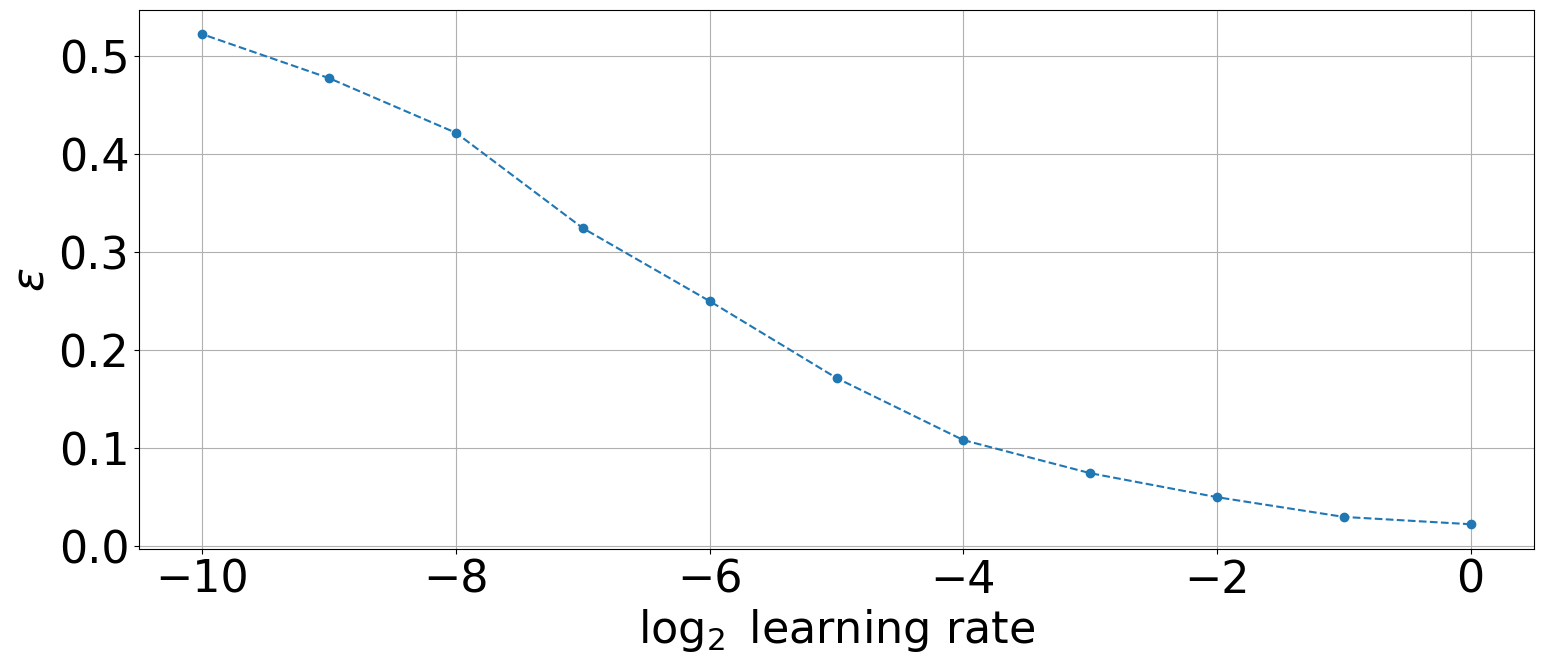

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list[2:]), torch.tensor(losses[2:]), '--o')
plt.xlabel('$\\log_2$ learning rate')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 5

losses = []
for lr in lr_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        SGD.fair_train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = SGD.fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 4.0	 loss: 7.797882080078125
learning rate: 2.0	 loss: 2.9623489379882812
learning rate: 1.0	 loss: 0.03466842323541641
learning rate: 0.5	 loss: 0.04448813572525978
learning rate: 0.25	 loss: 0.05212162435054779
learning rate: 0.125	 loss: 0.07549691200256348
learning rate: 0.0625	 loss: 0.11803260445594788
learning rate: 0.03125	 loss: 0.16876006126403809
learning rate: 0.015625	 loss: 0.24584326148033142
learning rate: 0.0078125	 loss: 0.32264864444732666
learning rate: 0.00390625	 loss: 0.41238489747047424
learning rate: 0.001953125	 loss: 0.47386419773101807
learning rate: 0.0009765625	 loss: 0.5244783759117126


From the plots, we see that learning rate = $0.5$ stably gives a low loss for basis dimensions 5.

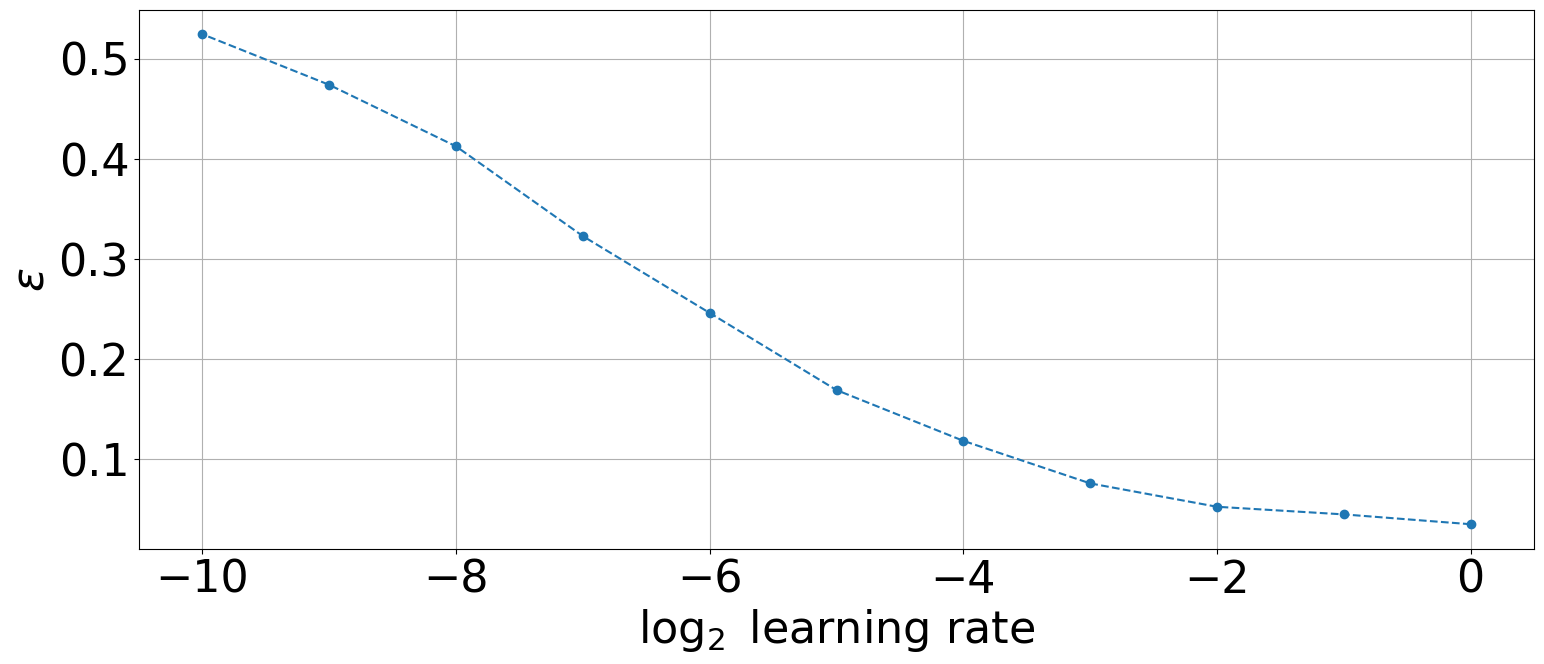

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list[2:]), torch.tensor(losses[2:]), '--o')
plt.xlabel('$\\log_2$ learning rate')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 7

losses = []
for lr in lr_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        SGD.fair_train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = SGD.fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 4.0	 loss: 8.319311141967773
learning rate: 2.0	 loss: 25.029462814331055
learning rate: 1.0	 loss: 0.049578167498111725
learning rate: 0.5	 loss: 1.025393009185791
learning rate: 0.25	 loss: 0.05582302063703537
learning rate: 0.125	 loss: 0.07573901116847992
learning rate: 0.0625	 loss: 0.11664033681154251
learning rate: 0.03125	 loss: 0.17151284217834473
learning rate: 0.015625	 loss: 0.2674548029899597
learning rate: 0.0078125	 loss: 0.33203816413879395
learning rate: 0.00390625	 loss: 0.4206441044807434
learning rate: 0.001953125	 loss: 0.4744987487792969
learning rate: 0.0009765625	 loss: 0.5274477005004883


From the plots, we see that learning rate = $0.5$ stably gives a low loss for basis dimensions 7.

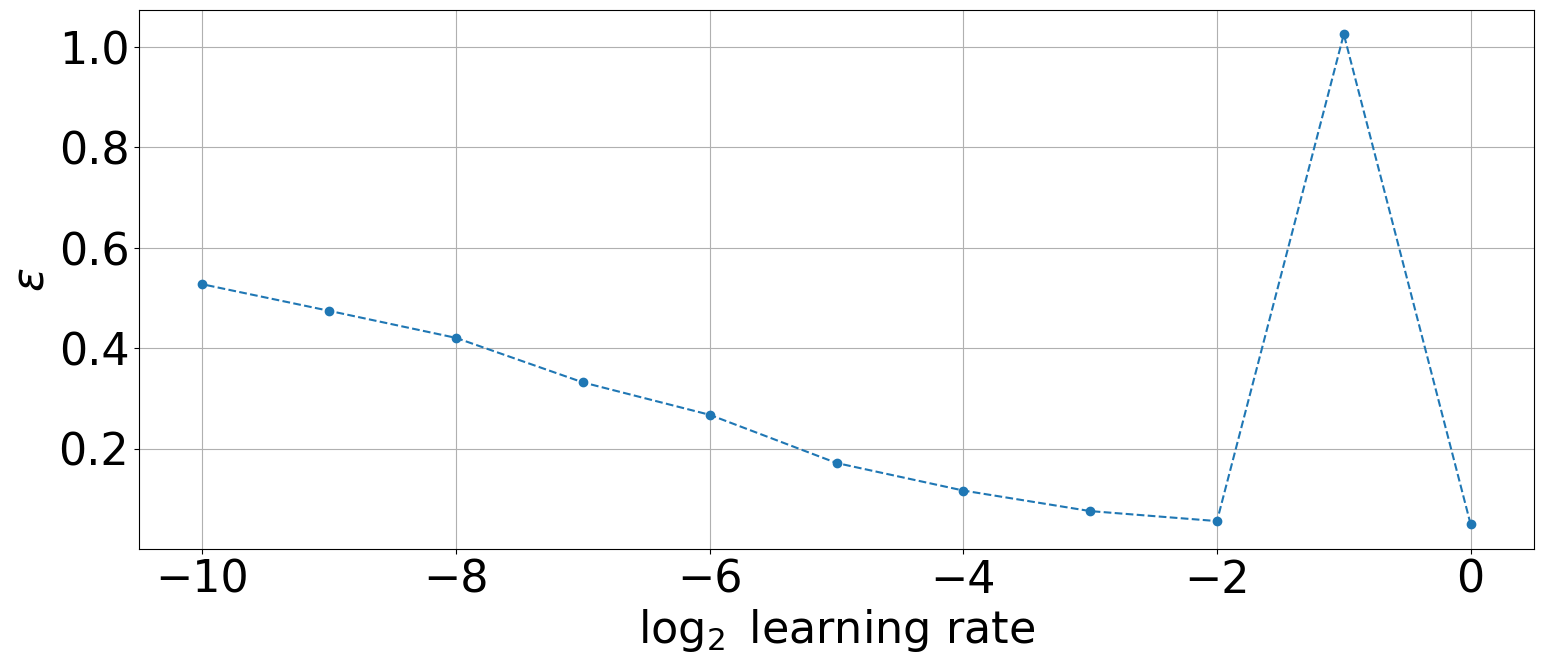

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list[2:]), torch.tensor(losses[2:]), '--o')
plt.xlabel('$\\log_2$ learning rate')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

###Next, we tune stochastic gradient descent.

For stochastic gradient descent, we are using shrinking learning rate $\frac{\alpha}{T}$ for iteration $T$. We shall tune $\alpha$.

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 3

losses = []
for alpha in alpha_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([0.1, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        SGD.fair_train_SGD(tune_SGD_data_loader, model, criterion, optimizer)

    loss = SGD.fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 16.0	 loss: 0.05747831612825394
alpha: 8.0	 loss: 0.07206960022449493
alpha: 4.0	 loss: 0.08426413685083389
alpha: 2.0	 loss: 0.12970930337905884
alpha: 1.0	 loss: 0.15969282388687134
alpha: 0.5	 loss: 0.2522071897983551
alpha: 0.25	 loss: 0.34039852023124695
alpha: 0.125	 loss: 0.4075910449028015
alpha: 0.0625	 loss: 0.5080386400222778
alpha: 0.03125	 loss: 0.5551321506500244
alpha: 0.015625	 loss: 0.579634964466095
alpha: 0.0078125	 loss: 0.5891046524047852
alpha: 0.00390625	 loss: 0.619204580783844


From the plot, we see that $\alpha = 4$ stably yields low loss for basis dimension 3.



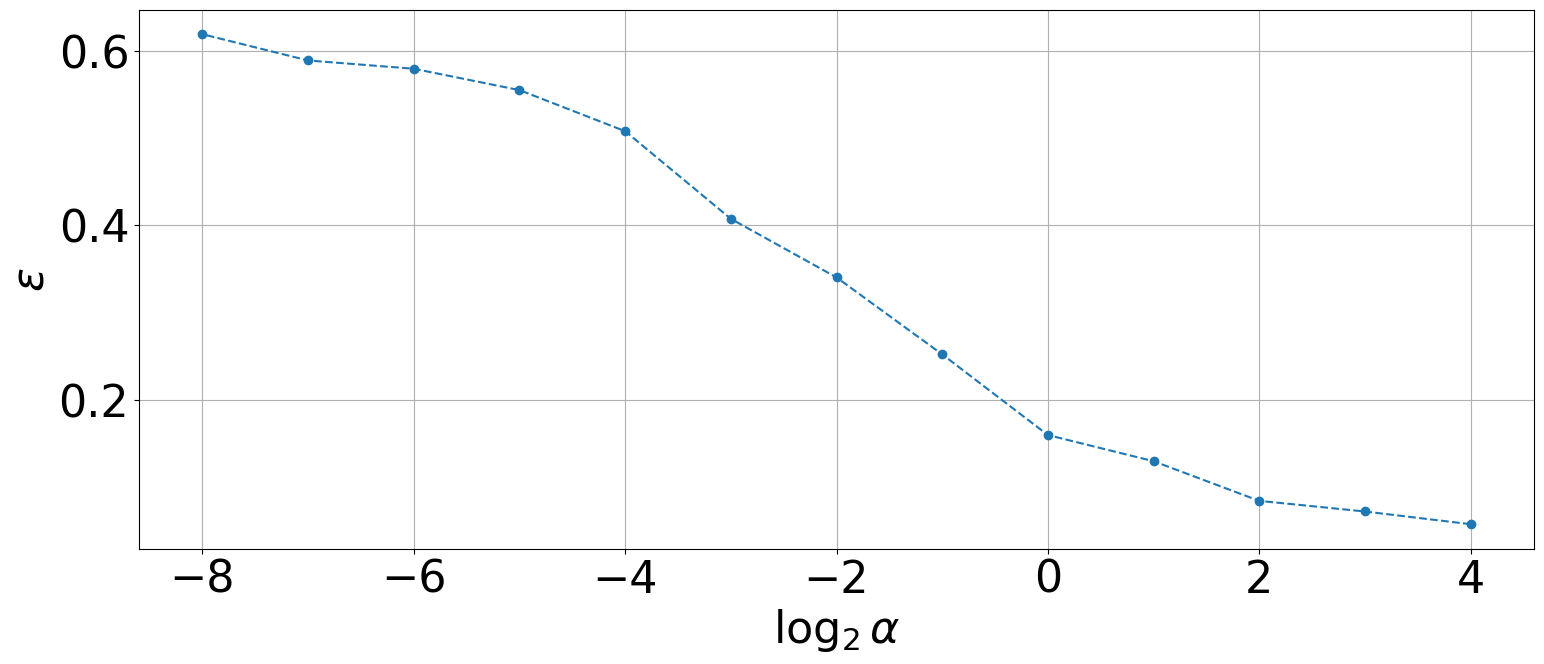

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), torch.tensor(losses), '--o')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 4

losses = []
for alpha in alpha_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([0.1, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        SGD.fair_train_SGD(tune_SGD_data_loader, model, criterion, optimizer)

    loss = SGD.fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 16.0	 loss: 0.05329572409391403
alpha: 8.0	 loss: 0.06090482324361801
alpha: 4.0	 loss: 0.08741861581802368
alpha: 2.0	 loss: 0.11416233330965042
alpha: 1.0	 loss: 0.15697407722473145
alpha: 0.5	 loss: 0.2801080048084259
alpha: 0.25	 loss: 0.30374470353126526
alpha: 0.125	 loss: 0.5230830907821655
alpha: 0.0625	 loss: 0.5155892968177795
alpha: 0.03125	 loss: 0.523331880569458
alpha: 0.015625	 loss: 0.5756393671035767
alpha: 0.0078125	 loss: 0.596881628036499
alpha: 0.00390625	 loss: 0.6556395888328552


From the plot, we see that $\alpha = 4$ stably yields low loss for basis dimension 4.



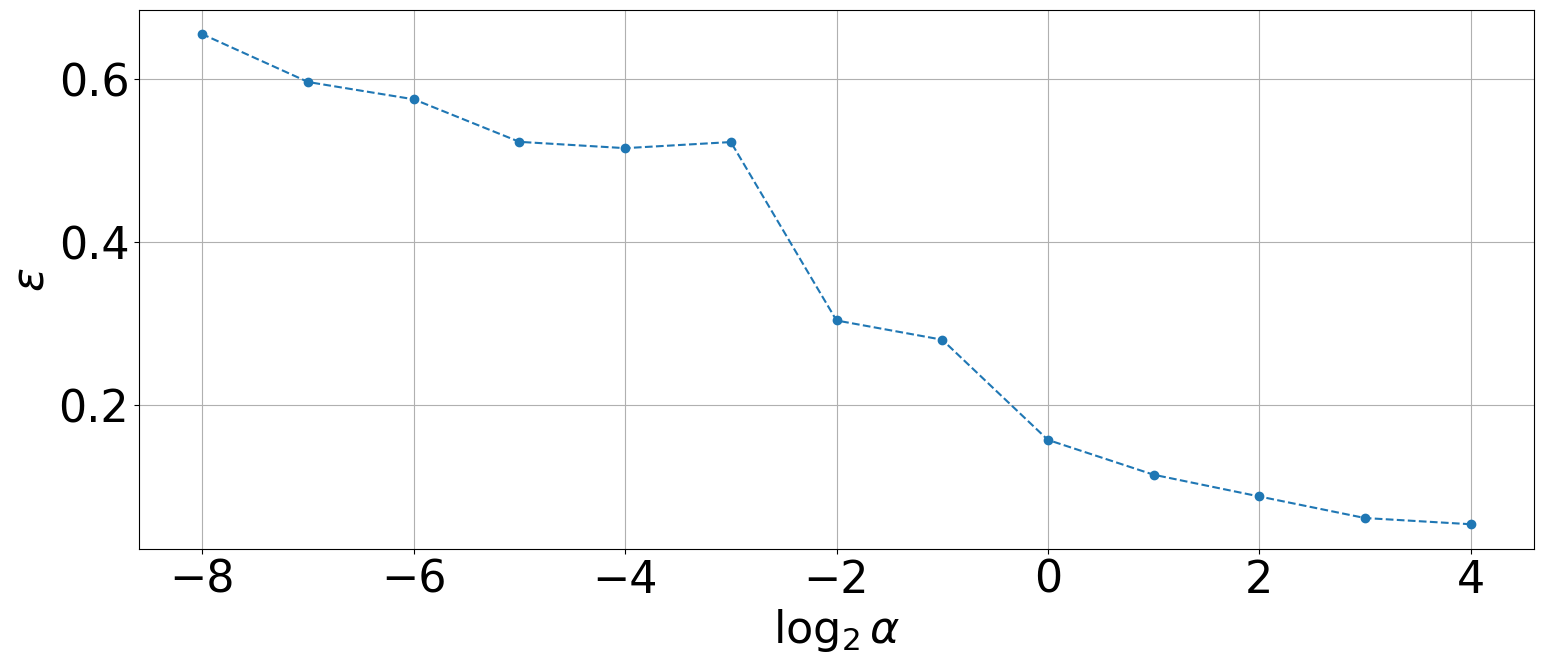

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), torch.tensor(losses), '--o')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 5

losses = []
for alpha in alpha_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([0.1, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        SGD.fair_train_SGD(tune_SGD_data_loader, model, criterion, optimizer)

    loss = SGD.fair_test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 16.0	 loss: 0.04866383224725723
alpha: 8.0	 loss: 0.0674123615026474
alpha: 4.0	 loss: 0.08574336767196655
alpha: 2.0	 loss: 0.1438950151205063
alpha: 1.0	 loss: 0.1514730155467987
alpha: 0.5	 loss: 0.21774058043956757
alpha: 0.25	 loss: 0.31940746307373047
alpha: 0.125	 loss: 0.5008350014686584
alpha: 0.0625	 loss: 0.5415816307067871
alpha: 0.03125	 loss: 0.5217517018318176
alpha: 0.015625	 loss: 0.5822649002075195
alpha: 0.0078125	 loss: 0.5948375463485718


From the plot, we see that $\alpha = 4$ stably yields low loss for basis dimension 5.



In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), torch.tensor(losses), '--o')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.grid(True)

## Visualizing convergence of our model

We use a coefficient profile plot for an arbitrarily selected coefficient (3) to visualize the convergence of our model.

In [ ]:
num_grid = 2**10
lambdas = np.linspace(lam_max, lam_min, num_grid)
delta_lam = (lam_max - lam_min)/(num_grid - 1)

In [ ]:
coeff_index = 3

In [ ]:
trace = 500 # run this again before plotting

#### Coefficient plot when we use exact gradient.

In [ ]:
# build the model
basis_dim = 13
epoch = trace * (2**3)
lr = 0.5**2

np.random.seed(8675309)
torch.manual_seed(8675309)
model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
thetas_SGD_history = []
for t in range(epoch):
    SGD.fair_train_SGD(GD_data_loader, model, criterion, optimizer)
    if (t+1) == trace:
        trace = 2*trace
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

In [ ]:
thetas_SGD.shape

(1024, 46)

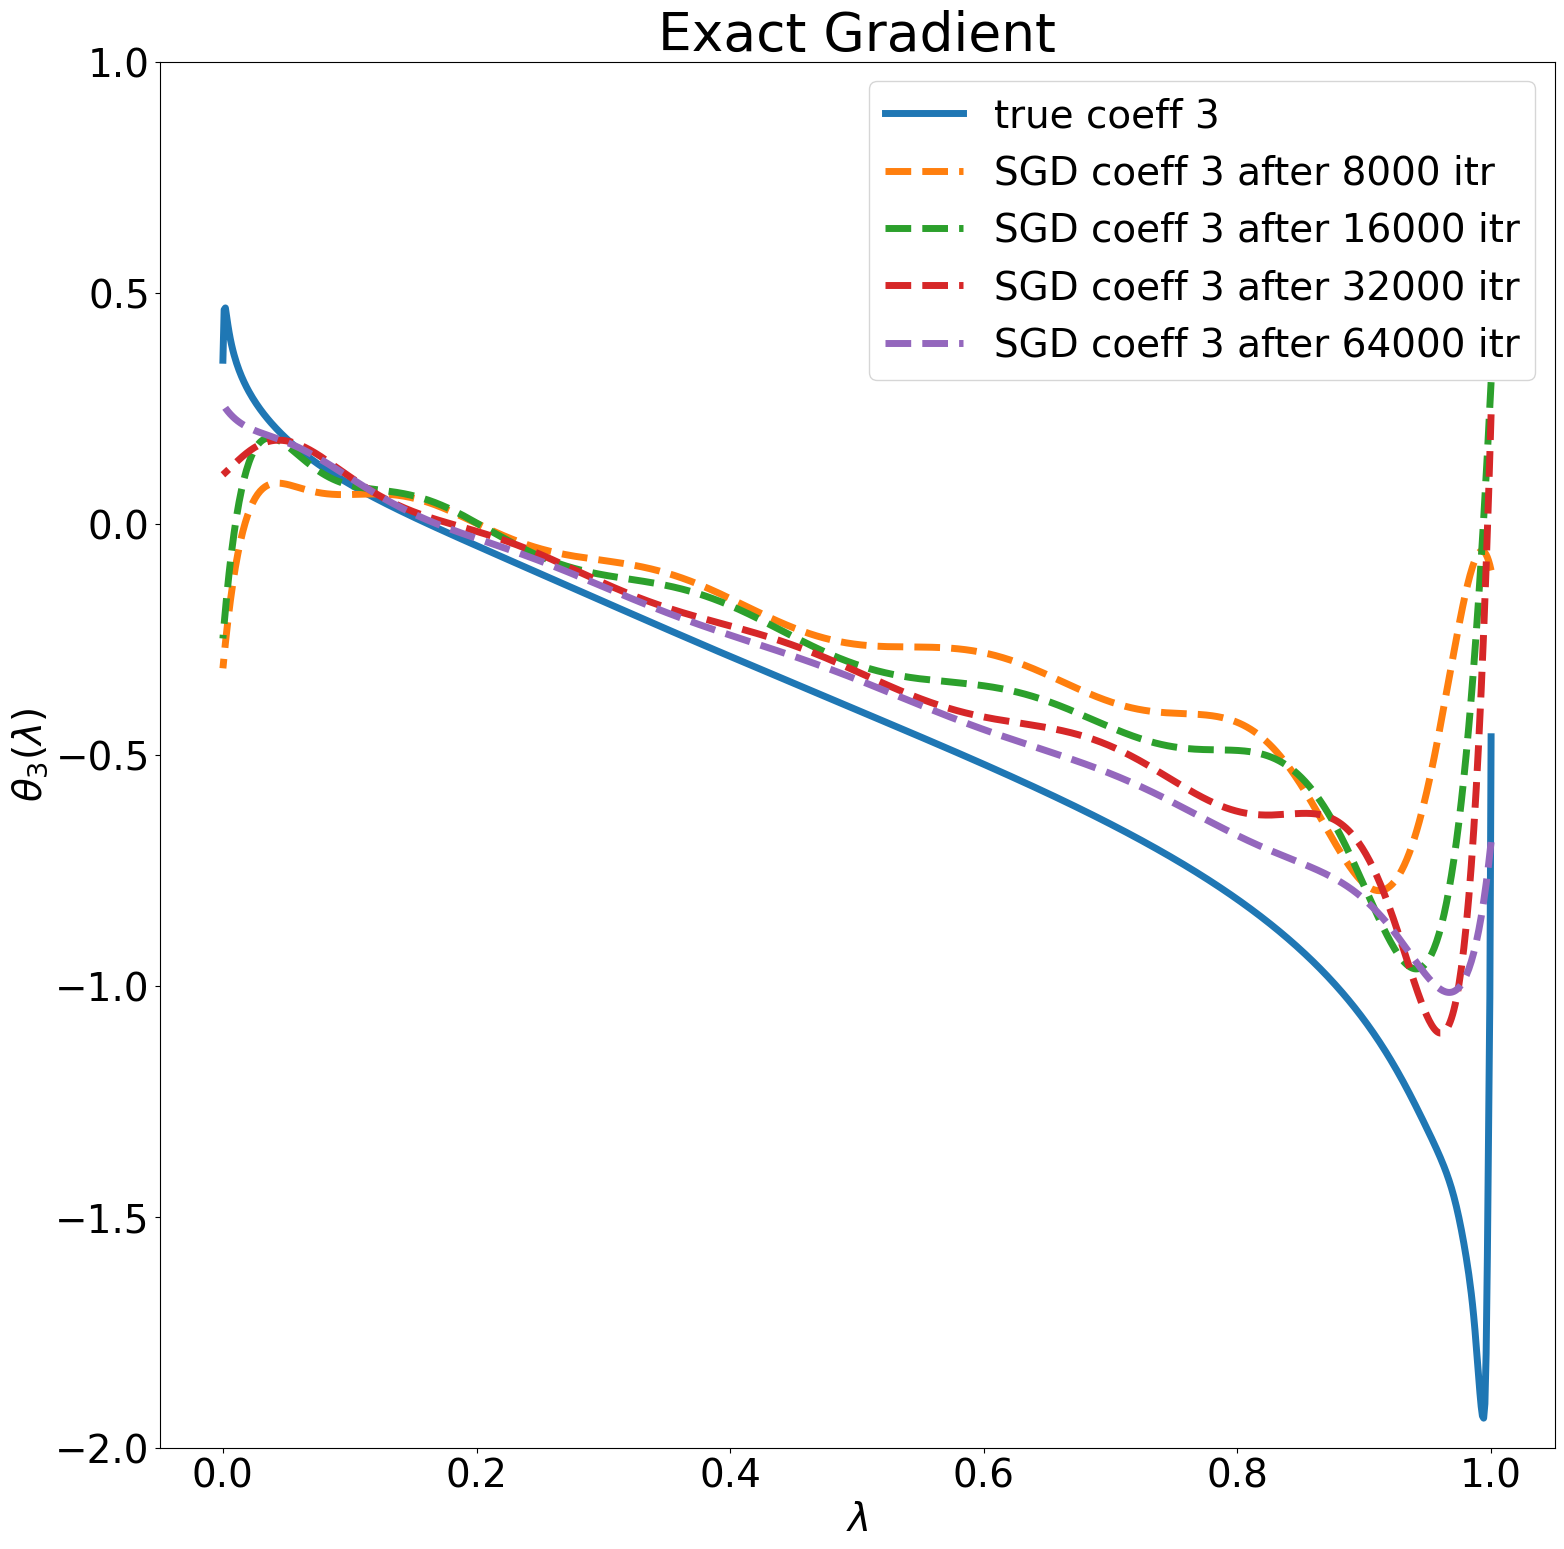

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a Matplotlib plot
plt.figure(figsize=(18, 18))
plt.plot(lambdas, true_thetas[:,coeff_index], linewidth=5, label=f'true coeff {coeff_index}')

for i in range(0, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,coeff_index], '--', linewidth=5, label=f'SGD coeff {coeff_index} after {trace*(2**i)} itr')

# Set global font size
mpl.rcParams['font.size'] = 32

font_size = 28
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$', fontsize=font_size)
plt.ylabel('$\\theta_{3}(\\lambda)$', fontsize=font_size)

plt.title('Exact Gradient')

plt.ylim(-2, 1)
# Add legend
plt.legend(fontsize=font_size)

# Show the plot
plt.show()

# save figure
plt.savefig("CPP_exact_3.png")


### Coefficient profile plot when we use noisy gradient

In [ ]:
# build the model
basis_dim = 13
epoch = trace * (2**3)
alpha = 2**4

np.random.seed(8675309)
torch.manual_seed(8675309)
model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer.zero_grad()
thetas_SGD_history = []
for t in range(epoch):
    # shrink learning rate
    lr = min([0.1, alpha/(t+1)])
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    SGD.fair_train_SGD(SGD_data_loader, model, criterion, optimizer)
    if (t+1) == trace:
        trace = 2*trace
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

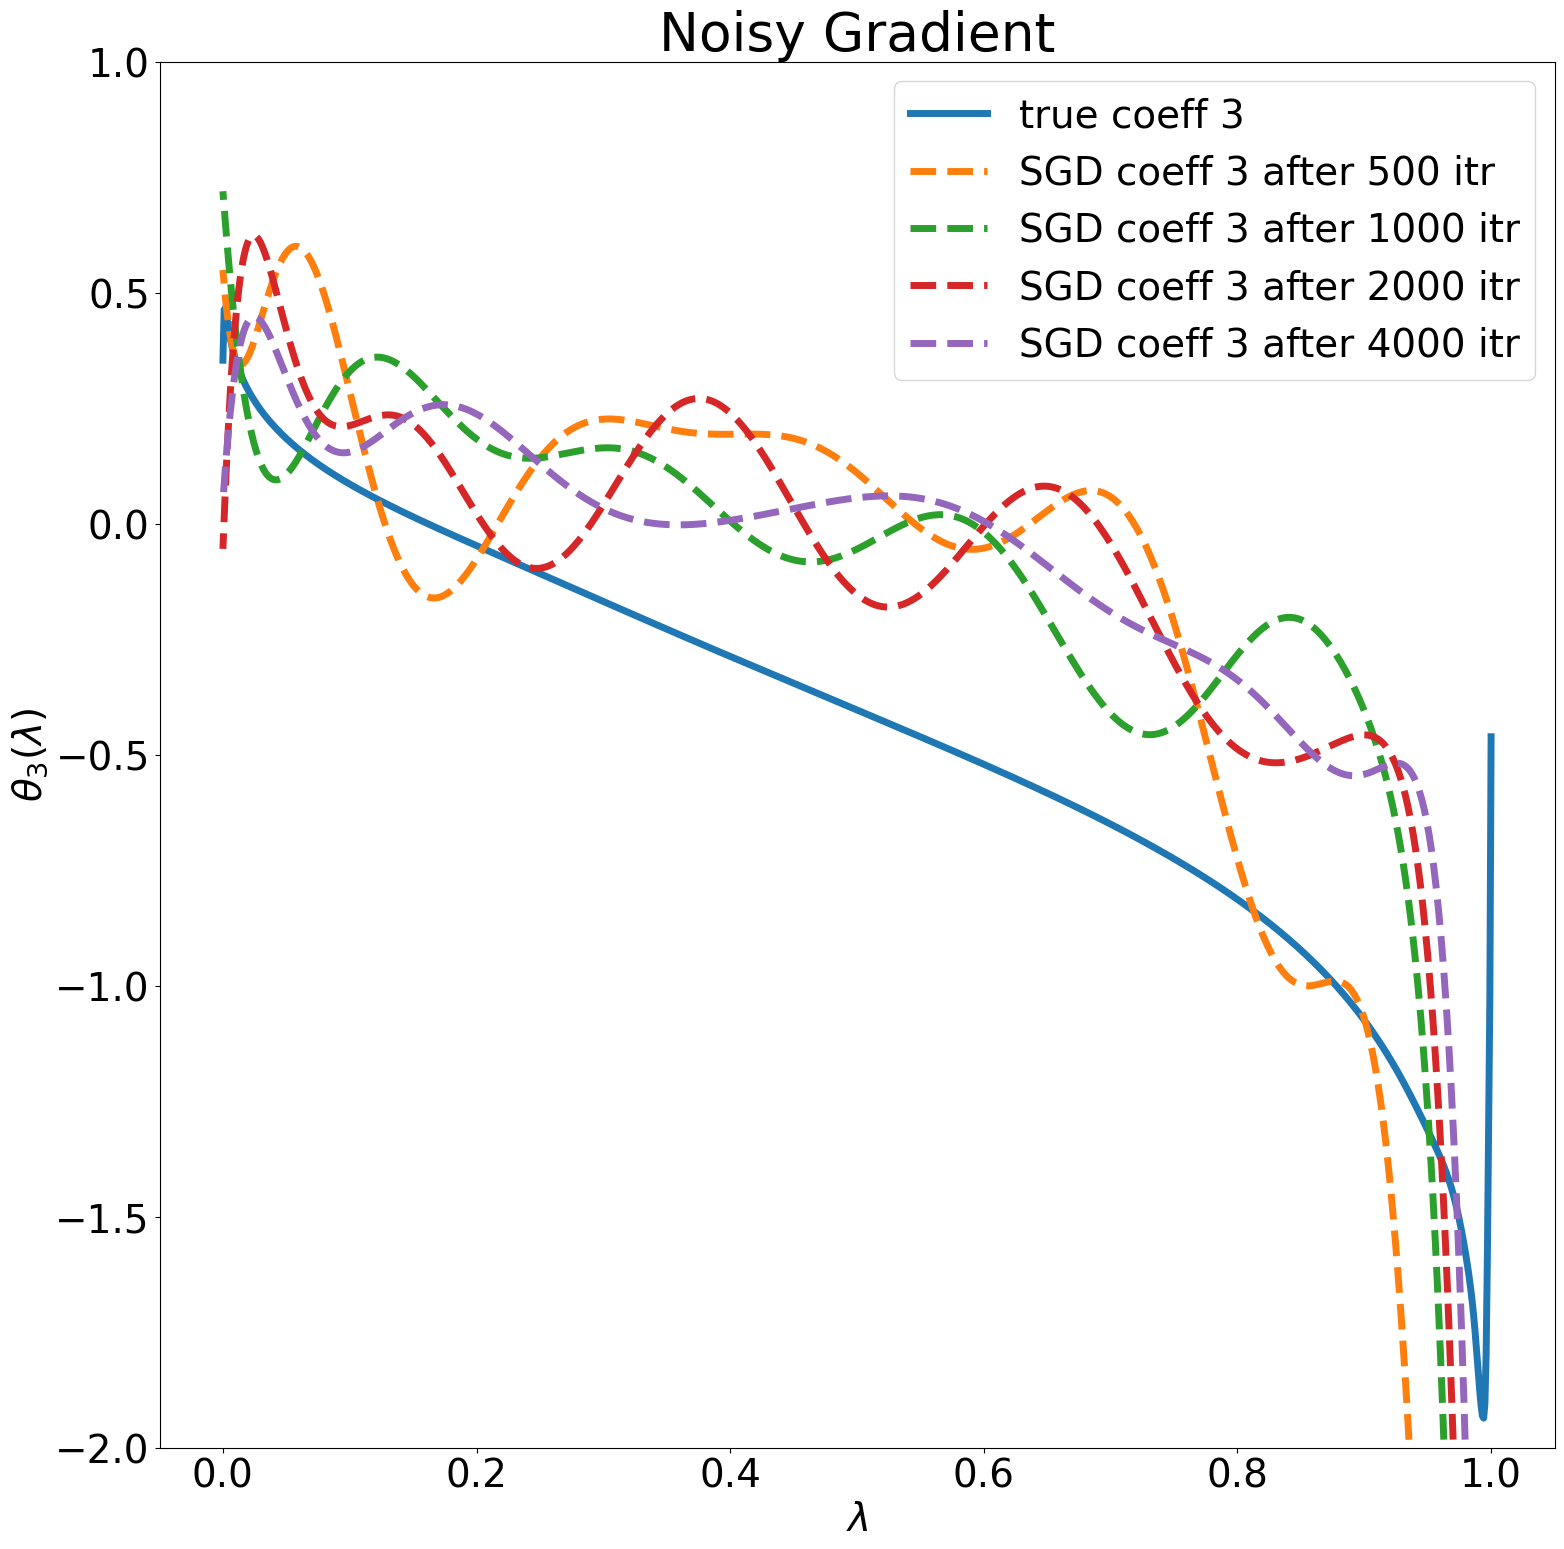

In [ ]:
# Create a Matplotlib plot
plt.figure(figsize=(18, 18))
plt.plot(lambdas, true_thetas[:,coeff_index], linewidth=5, label=f'true coeff {coeff_index}')

for i in range(0, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,coeff_index], '--', linewidth=5, label=f'SGD coeff {coeff_index} after {trace*(2**i)} itr')

# Set global font size
mpl.rcParams['font.size'] = 32

font_size = 28
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$', fontsize=font_size)
plt.ylabel('$\\theta_{3}(\\lambda)$', fontsize=font_size)
plt.title('Noisy Gradient')

plt.ylim(-2, 1)

# Show the plot
# plt.show()

# save figure
plt.savefig("CPP_noisy_3.png")

# Compare Learning the Optimal Solution Path with Naive Grid Search

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import time

## First, we run both methods for the exact gradient case.

### Learning the solution path:

Train the SGD model for our method using exact gradient and record the sup error along the solution path ($\epsilon$) achieved after executing some number of gradient calls (epochs).

We use the previously tuned learning rate $2^{-6}$.

In [35]:
epochs = 200000

In [ ]:
basis_dim = 3
lr = 0.5

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, model = SGD.learn_optimal_solution_path(input_dim, basis_dim, phi_lam, epochs,
                                                                   GD_data_loader, test_data_loader, criterion,
                                                                   lam_min, lam_max, true_losses,
                                                                   lr=lr, SGD=False, obj='fairness',
                                                                   intercept=True, trace_frequency=1000)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 1000 complete--------
# itr: 1000	 sup error: 0.0391506305859366
--------approximate solution path for # itr = 2000 complete--------
# itr: 2000	 sup error: 0.0689924839316518
--------approximate solution path for # itr = 3000 complete--------
# itr: 3000	 sup error: 0.058994860850361874
--------approximate solution path for # itr = 4000 complete--------
# itr: 4000	 sup error: 0.06420439621069818
--------approximate solution path for # itr = 5000 complete--------
# itr: 5000	 sup error: 0.07453113188603311
--------approximate solution path for # itr = 6000 complete--------
# itr: 6000	 sup error: 0.07240858813383966
--------approximate solution path for # itr = 7000 complete--------
# itr: 7000	 sup error: 0.03846745704868226
--------approximate solution path for # itr = 8000 complete--------
# itr: 8000	 sup error: 0.06291342666008859
--------approximate solution path for # itr = 9000 complete--------
# itr: 9000	 sup error: 0.03311571063

In [ ]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/SGD_results_exact.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['num_itr', 'sup_err_13'])

#     # Write the data from your lists
#     for i in range(len(epochs)):
#         csv_writer.writerow([epochs[i], sup_err_history[i]])

In [ ]:
# for i in range(len(sup_err_history)):
#     sup_err_history[i] = np.min(sup_err_history[:i+1])

In [ ]:
# file_path = '/content/drive/MyDrive/Experiments/SGD_results_exact.csv'
file_path = 'SGD_results_exact.csv'

SGD_results_exact = pd.DataFrame(np.column_stack((num_itr_history, sup_err_history)), columns=['num_itr', 'sup_err_3'])

# Save the DataFrame to a CSV file
SGD_results_exact.to_csv(file_path, index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame
df

In [ ]:
basis_dim = 5
lr = 0.5

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, model = SGD.learn_optimal_solution_path(input_dim, basis_dim, phi_lam, epochs,
                                                                   GD_data_loader, test_data_loader, criterion,
                                                                   lam_min, lam_max, true_losses,
                                                                   lr=lr, SGD=False, obj='fairness',
                                                                   intercept=True, trace_frequency=1000)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 1000 complete--------
# itr: 1000	 sup error: 0.021212071180343656
--------approximate solution path for # itr = 2000 complete--------
# itr: 2000	 sup error: 0.027864938132552197
--------approximate solution path for # itr = 3000 complete--------
# itr: 3000	 sup error: 0.03125660260775476
--------approximate solution path for # itr = 4000 complete--------
# itr: 4000	 sup error: 0.025707814373163274
--------approximate solution path for # itr = 5000 complete--------
# itr: 5000	 sup error: 0.020930639930156758
--------approximate solution path for # itr = 6000 complete--------
# itr: 6000	 sup error: 0.025872727386740735
--------approximate solution path for # itr = 7000 complete--------
# itr: 7000	 sup error: 0.01734619358467171
--------approximate solution path for # itr = 8000 complete--------
# itr: 8000	 sup error: 0.026055395603180015
--------approximate solution path for # itr = 9000 complete--------
# itr: 9000	 sup error: 0.0266

In [ ]:
# Add a new column for a different basis dimension
df['sup_err_5'] = sup_err_history

# Save the updated DataFrame back to the CSV file
df.to_csv(file_path, index=False)

In [ ]:
epochs = 530000

basis_dim = 7
lr = 0.5

num_itr_history, sup_err_history = SGD.learn_optimal_solution_path(input_dim, basis_dim, phi_lam, epochs,
                                                                   GD_data_loader, test_data_loader, criterion,
                                                                   lam_min, lam_max, true_losses,
                                                                   lr=lr, SGD=False, obj='fairness',
                                                                   intercept=True, trace_frequency=1000)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 1000 complete--------
# itr: 1000	 sup error: 0.02379039628067403
--------approximate solution path for # itr = 2000 complete--------
# itr: 2000	 sup error: 0.01474568247795105
--------approximate solution path for # itr = 3000 complete--------
# itr: 3000	 sup error: 0.011237071357754758
--------approximate solution path for # itr = 4000 complete--------
# itr: 4000	 sup error: 0.02960283448555856
--------approximate solution path for # itr = 5000 complete--------
# itr: 5000	 sup error: 0.010425486172607634
--------approximate solution path for # itr = 6000 complete--------
# itr: 6000	 sup error: 0.01814755005398183
--------approximate solution path for # itr = 7000 complete--------
# itr: 7000	 sup error: 0.04265592386582284
--------approximate solution path for # itr = 8000 complete--------
# itr: 8000	 sup error: 0.01884514605262666
--------approximate solution path for # itr = 9000 complete--------
# itr: 9000	 sup error: 0.01223029

In [ ]:
# Add a new column for a different basis dimension
df['sup_err_7'] = sup_err_history[:200000]

# Save the updated DataFrame back to the CSV file
df.to_csv(file_path, index=False)

In [ ]:
basis_dim = 9
lr = 0.25

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, model = SGD.learn_optimal_solution_path(input_dim, basis_dim, phi_lam, epochs,
                                                                   GD_data_loader, test_data_loader, criterion,
                                                                   lam_min, lam_max, true_losses,
                                                                   lr=lr, SGD=False, obj='fairness',
                                                                   intercept=True, trace_frequency=1000)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 1000 complete--------
# itr: 1000	 sup error: 0.029148578643798884
--------approximate solution path for # itr = 2000 complete--------
# itr: 2000	 sup error: 0.01856686174869543
--------approximate solution path for # itr = 3000 complete--------
# itr: 3000	 sup error: 0.015547968447208488
--------approximate solution path for # itr = 4000 complete--------
# itr: 4000	 sup error: 0.0133076682686806
--------approximate solution path for # itr = 5000 complete--------
# itr: 5000	 sup error: 0.01187230646610267
--------approximate solution path for # itr = 6000 complete--------
# itr: 6000	 sup error: 0.010651290416717599
--------approximate solution path for # itr = 7000 complete--------
# itr: 7000	 sup error: 0.01139620551475673
--------approximate solution path for # itr = 8000 complete--------
# itr: 8000	 sup error: 0.009030185639858301
--------approximate solution path for # itr = 9000 complete--------
# itr: 9000	 sup error: 0.0111460

In [ ]:
# file_path = '/content/drive/MyDrive/Experiments/SGD_results_exact.csv'
df = pd.read_csv(file_path)

# df = df.rename(columns={'sup_err': 'sup_err_9'})

# Add a new column for a different basis dimension
df['sup_err_9'] = sup_err_history

# Save the updated DataFrame back to the CSV file
df.to_csv(file_path, index=False)

### Naive Grid Search:

In [42]:
lam_max = 1
lam_min = 0
lr = 2
max_epochs = 5000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** np.arange(6, 15, 0.3)

In [43]:
total_itr_list = []
sup_error_list = []
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = round(1 / np.sqrt(delta))

    start_time = time.time()
    total_itr, reg_params, intercepts, weights = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                trainDataLoader=GD_data_loader,
                                data_input_dim=input_dim, obj='fairness',
                                lr=lr, SGD=False, testDataLoader=test_data_loader,
                                true_loss_list=true_losses, stopping_criterion=delta)

    end_time = time.time()
    execution_time = end_time - start_time

    total_itr_list.append(total_itr)

    sup_error = NGS.get_sup_error(lam_min, lam_max, true_losses, intercepts,
                                  weights, reg_params, test_data_loader, criterion, obj='fairness')

    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")

total_itr_list = np.array(total_itr_list)
sup_error_list = np.array(sup_error_list)

grid #: 8	 total iteration #: 490	 sup error: 0.2468730509281159	 Execution time: 13.507238388061523 seconds
grid #: 9	 total iteration #: 700	 sup error: 0.21782237291336065	 Execution time: 13.716545581817627 seconds
grid #: 10	 total iteration #: 970	 sup error: 0.19266780465841296	 Execution time: 18.880154132843018 seconds
grid #: 11	 total iteration #: 1330	 sup error: 0.1713241189718247	 Execution time: 25.69708800315857 seconds
grid #: 12	 total iteration #: 1820	 sup error: 0.15712156891822815	 Execution time: 34.445327281951904 seconds
grid #: 13	 total iteration #: 2430	 sup error: 0.14260300993919375	 Execution time: 46.3371000289917 seconds
grid #: 15	 total iteration #: 3400	 sup error: 0.12104111537337311	 Execution time: 67.52000975608826 seconds
grid #: 17	 total iteration #: 4660	 sup error: 0.10875639319419869	 Execution time: 90.72683572769165 seconds
grid #: 18	 total iteration #: 6120	 sup error: 0.10317988693714149	 Execution time: 119.88790512084961 seconds
grid

In [ ]:
NGS_results_exact = pd.DataFrame(np.column_stack((total_itr_list, sup_error_list)), columns=['num_itr', 'sup_err'])

# Save the DataFrame to a CSV file
NGS_results_exact.to_csv('NGS_results_exact.csv', index=False)

# Read the CSV file into a DataFrame
NGS_results_exact = pd.read_csv('NGS_results_exact.csv')

# Display the DataFrame
NGS_results_exact

In [44]:
import csv

csv_file_path = '/content/drive/MyDrive/Experiments/NGS_results_exact.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    # Create a CSV writer
    csv_writer = csv.writer(csv_file)

    # Write the headers
    csv_writer.writerow(['num_itr', 'sup_err'])

    # Write the data from your lists
    for i in range(len(total_itr_list)):
        csv_writer.writerow([total_itr_list[i], sup_error_list[i]])

In [ ]:
# for i in range(len(sup_error_list)):
#     sup_error_list[i] = np.min(sup_error_list[:i+1])

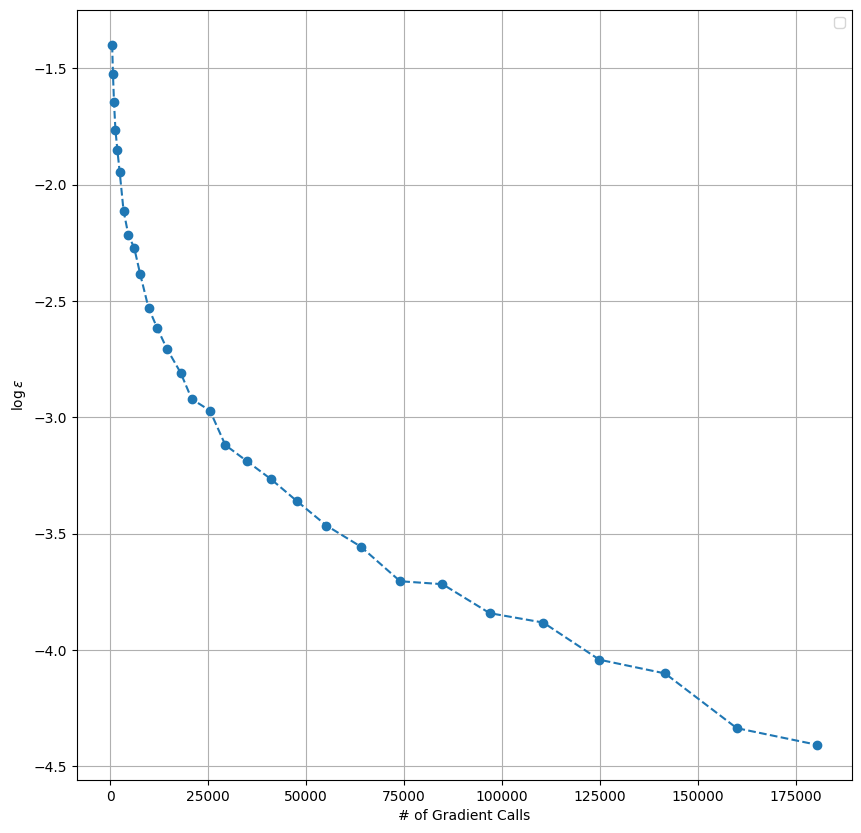

In [45]:
# plot result of learning the solution path
plt.figure(figsize=(10,10))
plt.plot(total_itr_list, np.log(sup_error_list), '--o')
plt.xlabel('# of Gradient Calls')
plt.ylabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

## Plot Naive Grid Search vs Learning the Optimal Solution Path for the exact gradient case

In [72]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS_results_exact.csv'
NGS_results_exact = pd.read_csv(csv_file_path)
num_itr_NGS = np.array(NGS_results_exact['num_itr'])
sup_err_NGS = np.array(NGS_results_exact['sup_err'])

In [73]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD_results_exact.csv'
SGD_results_exact = pd.read_csv(csv_file_path)
num_itr_SGD = np.array(SGD_results_exact['num_itr'])
sup_err_SGD_3 = np.array(SGD_results_exact['sup_err_3'])
sup_err_SGD_5 = np.array(SGD_results_exact['sup_err_5'])
sup_err_SGD_7 = np.array(SGD_results_exact['sup_err_7'])

In [ ]:
# for i in range(len(sup_err_SGD)):
#     sup_err_SGD[i] = np.min(sup_err_SGD[:i+1])

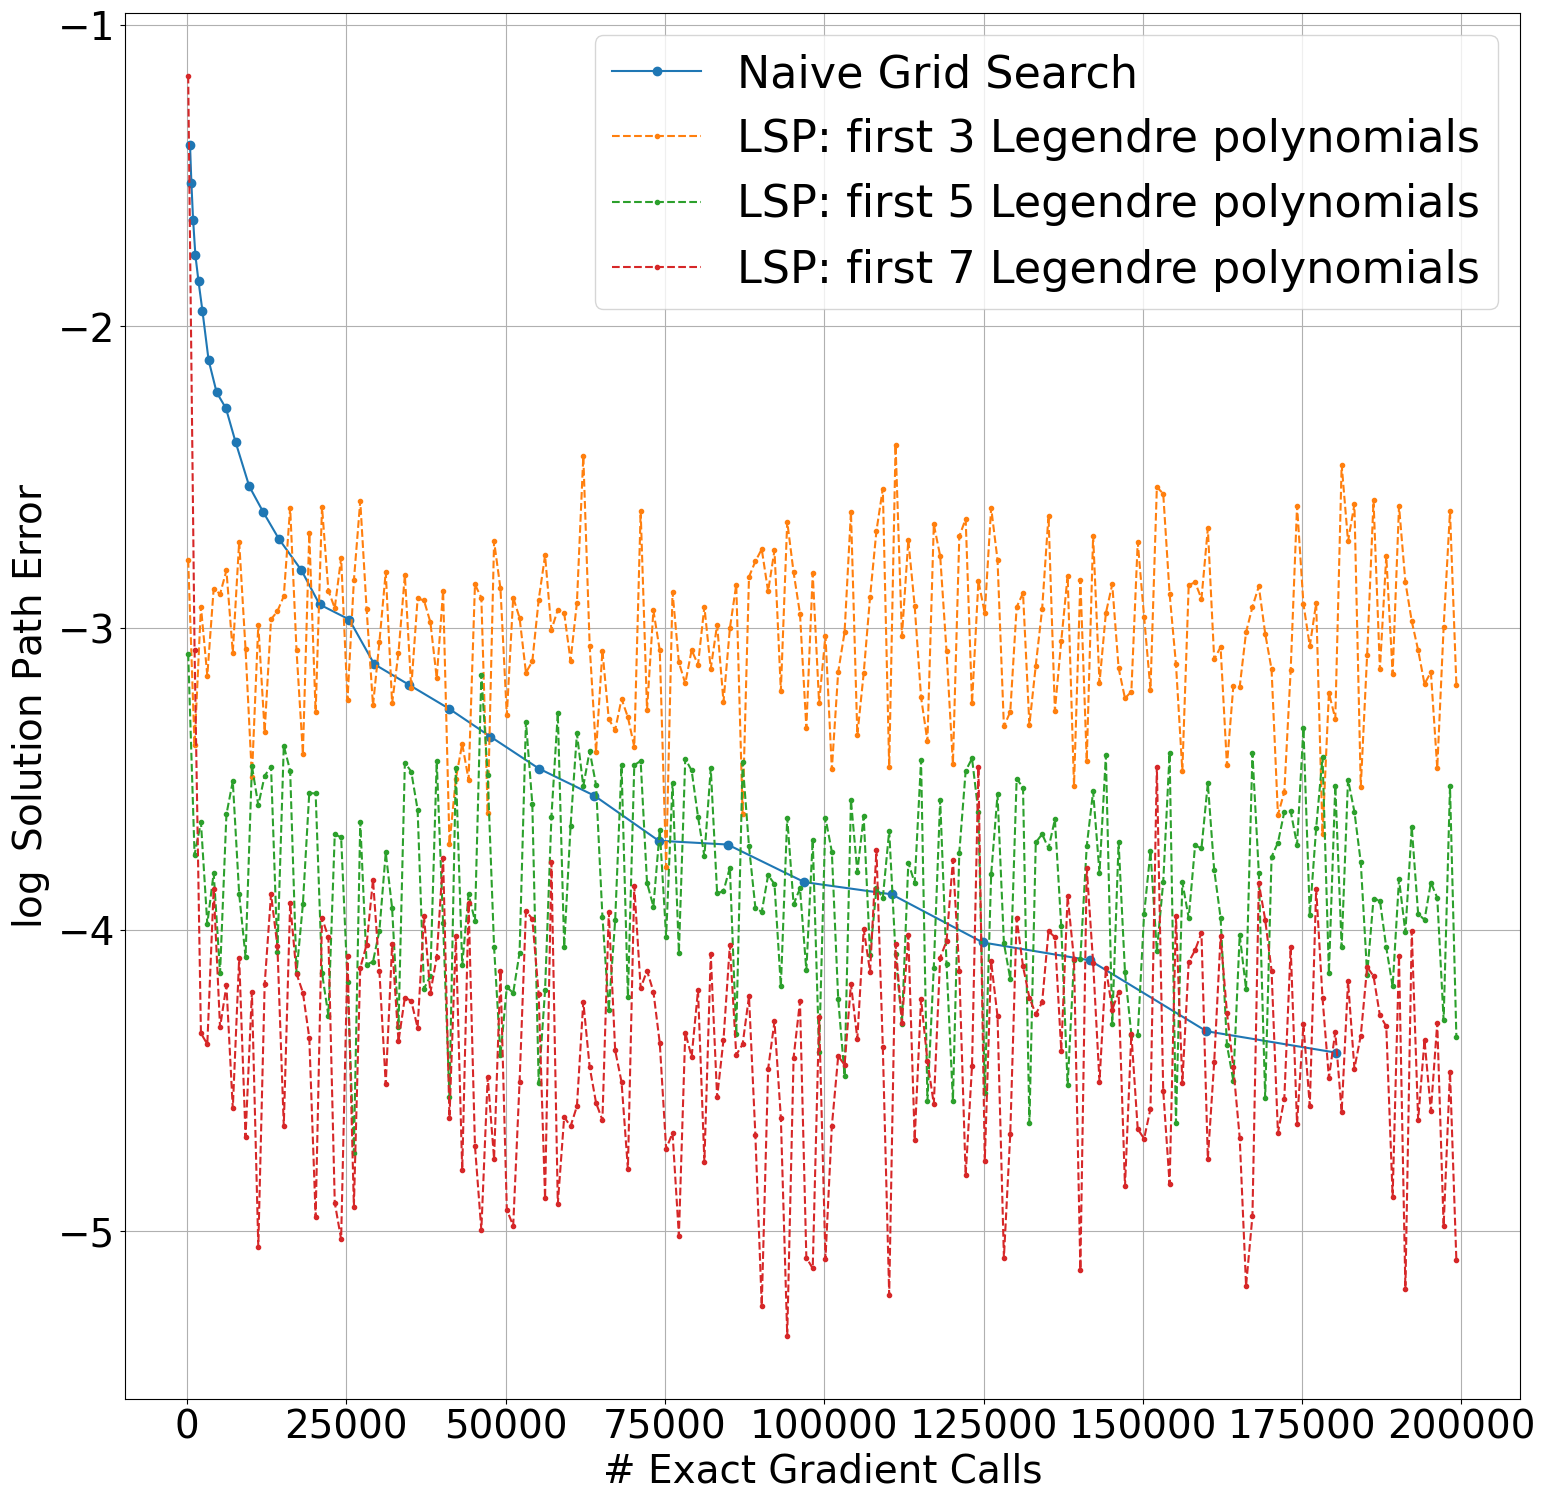

In [77]:
# plot result of learning the solution path
plt.figure(figsize=(18,18))
plt.plot(num_itr_NGS, np.log(sup_err_NGS), '-o', label = "Naive Grid Search")
plt.plot(num_itr_SGD[1::10], np.log(sup_err_SGD_3[1::10]), '--.', label = "LSP: first 3 Legendre polynomials")
plt.plot(num_itr_SGD[1::10], np.log(sup_err_SGD_5[1::10]), '--.', label = "LSP: first 5 Legendre polynomials")
plt.plot(num_itr_SGD[1::10], np.log(sup_err_SGD_7[1::10]), '--.', label = "LSP: first 7 Legendre polynomials")

# Set global font size
mpl.rcParams['font.size'] = 32

font_size = 28
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

plt.xlabel('# Exact Gradient Calls', fontsize=font_size)
plt.ylabel('$\\log$ Solution Path Error', fontsize=font_size)
plt.legend()
plt.grid(True)

## Then, we run both methods for the noisy gradient case.

### Learning the solution path:

Train the SGD model for our method using noisy gradient (mini-batch SGD) and record the sup error along the solution path ($\epsilon$) achieved after executing some number of gradient calls (epochs).

We use the previously tuned shrinking rate $\alpha = 1$.

In [36]:
epochs = 20000

In [ ]:
basis_dim = 3
alpha = 4
init_lr = 0.1

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, model = SGD.learn_optimal_solution_path(input_dim, basis_dim, phi_lam, epochs,
                                                                          SGD_data_loader, test_data_loader, criterion,
                                                                          lam_min, lam_max, true_losses,
                                                                          alpha=alpha, init_lr=init_lr, SGD=True,
                                                                          obj='fairness',
                                                                          record_frequency=50, trace_frequency=100)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 100 complete--------
# itr: 100	 sup error: 0.07442298861133168
--------approximate solution path for # itr = 200 complete--------
# itr: 200	 sup error: 0.05685558499681065
--------approximate solution path for # itr = 300 complete--------
# itr: 300	 sup error: 0.06379422875033924
--------approximate solution path for # itr = 400 complete--------
# itr: 400	 sup error: 0.050471558737626765
--------approximate solution path for # itr = 500 complete--------
# itr: 500	 sup error: 0.051018595266214106
--------approximate solution path for # itr = 600 complete--------
# itr: 600	 sup error: 0.04237372757779667
--------approximate solution path for # itr = 700 complete--------
# itr: 700	 sup error: 0.049319497811666224
--------approximate solution path for # itr = 800 complete--------
# itr: 800	 sup error: 0.04577848272310803
--------approximate solution path for # itr = 900 complete--------
# itr: 900	 sup error: 0.04536854432808468
-------

In [ ]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/SGD_results_noisy.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['num_itr', 'sup_err_3'])

#     # Write the data from your lists
#     for i in range(len(epochs)):
#         csv_writer.writerow([epochs[i], sup_err_history[i]])

In [ ]:
# for i in range(len(sup_err_history)):
#     sup_err_history[i] = np.min(sup_err_history[:i+1])
# # print(model_SGD.linear.weight)

In [ ]:
file_path = 'SGD_results_noisy.csv'

SGD_results_noisy = pd.DataFrame(np.column_stack((num_itr_history, sup_err_history)), columns=['num_itr', 'sup_err_3'])

# Save the DataFrame to a CSV file
SGD_results_noisy.to_csv(file_path, index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame
df

,num_itr,sup_err_3
0,50.0,0.079872
1,100.0,0.074423
2,150.0,0.055727
3,200.0,0.056856
4,250.0,0.061956
...,...,...
395,19800.0,0.047142
396,19850.0,0.047238
397,19900.0,0.046526
398,19950.0,0.046902


In [ ]:
basis_dim = 4
alpha = 4
init_lr = 0.1

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, model = SGD.learn_optimal_solution_path(input_dim, basis_dim, phi_lam, epochs,
                                                                   SGD_data_loader, test_data_loader, criterion,
                                                                   lam_min, lam_max, true_losses,
                                                                   alpha=alpha, init_lr=init_lr, SGD=True,
                                                                   obj='fairness',
                                                                   record_frequency=50, trace_frequency=100)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 100 complete--------
# itr: 100	 sup error: 0.06639673145400593
--------approximate solution path for # itr = 200 complete--------
# itr: 200	 sup error: 0.04096347093582159
--------approximate solution path for # itr = 300 complete--------
# itr: 300	 sup error: 0.02890646457672119
--------approximate solution path for # itr = 400 complete--------
# itr: 400	 sup error: 0.03077143430709839
--------approximate solution path for # itr = 500 complete--------
# itr: 500	 sup error: 0.030136495828628596
--------approximate solution path for # itr = 600 complete--------
# itr: 600	 sup error: 0.03331947326660156
--------approximate solution path for # itr = 700 complete--------
# itr: 700	 sup error: 0.028315693140029907
--------approximate solution path for # itr = 800 complete--------
# itr: 800	 sup error: 0.03309449553489685
--------approximate solution path for # itr = 900 complete--------
# itr: 900	 sup error: 0.02817434072494507
--------

In [ ]:
basis_dim = 4
alpha = 4
init_lr = 0.1

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, model = SGD.learn_optimal_solution_path(input_dim, basis_dim, phi_lam, epochs,
                                                                   SGD_data_loader, test_data_loader, criterion,
                                                                   lam_min, lam_max, true_losses,
                                                                   alpha=alpha, init_lr=init_lr, SGD=True,
                                                                   obj='fairness',
                                                                   record_frequency=50, trace_frequency=100)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 100 complete--------
# itr: 100	 sup error: 0.06639673145400593
--------approximate solution path for # itr = 200 complete--------
# itr: 200	 sup error: 0.04096347093582159
--------approximate solution path for # itr = 300 complete--------
# itr: 300	 sup error: 0.02890646457672119
--------approximate solution path for # itr = 400 complete--------
# itr: 400	 sup error: 0.03077143430709839
--------approximate solution path for # itr = 500 complete--------
# itr: 500	 sup error: 0.030136495828628596
--------approximate solution path for # itr = 600 complete--------
# itr: 600	 sup error: 0.03331947326660156
--------approximate solution path for # itr = 700 complete--------
# itr: 700	 sup error: 0.028315693140029907
--------approximate solution path for # itr = 800 complete--------
# itr: 800	 sup error: 0.03309449553489685
--------approximate solution path for # itr = 900 complete--------
# itr: 900	 sup error: 0.02817434072494507
--------

In [ ]:
file_path = 'SGD_results_noisy.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Add a new column for basis dimension 5
df['sup_err_4'] = sup_err_history

# Save the updated DataFrame back to the CSV file
df.to_csv(file_path, index=False)

In [38]:
basis_dim = 5
alpha = 4
init_lr = 0.1

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history = SGD.learn_optimal_solution_path(input_dim, basis_dim, phi_lam, epochs,
                                                                   SGD_data_loader, test_data_loader, criterion,
                                                                   lam_min, lam_max, true_losses,
                                                                   alpha=alpha, init_lr=init_lr, SGD=True,
                                                                   obj='fairness',
                                                                   record_frequency=50, trace_frequency=100)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 100 complete--------
# itr: 100	 sup error: 0.04469746351242071
--------approximate solution path for # itr = 200 complete--------
# itr: 200	 sup error: 0.04195532202720642
--------approximate solution path for # itr = 300 complete--------
# itr: 300	 sup error: 0.041019111871719416
--------approximate solution path for # itr = 400 complete--------
# itr: 400	 sup error: 0.03226757049560547
--------approximate solution path for # itr = 500 complete--------
# itr: 500	 sup error: 0.02687874436378479
--------approximate solution path for # itr = 600 complete--------
# itr: 600	 sup error: 0.03545558452606201
--------approximate solution path for # itr = 700 complete--------
# itr: 700	 sup error: 0.0295568257570267
--------approximate solution path for # itr = 800 complete--------
# itr: 800	 sup error: 0.030685067176818903
--------approximate solution path for # itr = 900 complete--------
# itr: 900	 sup error: 0.02987194061279297
--------a

In [41]:
file_path = 'SGD_results_noisy.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Add a new column for basis dimension 5
df['sup_err_5'] = sup_err_history

# Save the updated DataFrame back to the CSV file
df.to_csv(file_path, index=False)

In [ ]:
basis_dim = 7
alpha = 4
init_lr = 0.1

np.random.seed(8675309)
torch.manual_seed(8675309)

num_itr_history, sup_err_history, model = SGD.learn_optimal_solution_path(input_dim, basis_dim, phi_lam, epochs,
                                                                   SGD_data_loader, test_data_loader, criterion,
                                                                   lam_min, lam_max, true_losses,
                                                                   alpha=alpha, init_lr=init_lr, SGD=True,
                                                                   obj='fairness',
                                                                   record_frequency=50, trace_frequency=100)
sup_err_history = np.array(sup_err_history)

--------approximate solution path for # itr = 100 complete--------
# itr: 100	 sup error: 0.05863964557647705
--------approximate solution path for # itr = 200 complete--------
# itr: 200	 sup error: 0.06315469741821289
--------approximate solution path for # itr = 300 complete--------
# itr: 300	 sup error: 0.04961672425270086
--------approximate solution path for # itr = 400 complete--------
# itr: 400	 sup error: 0.04473420977592468
--------approximate solution path for # itr = 500 complete--------
# itr: 500	 sup error: 0.03390395641326904
--------approximate solution path for # itr = 600 complete--------
# itr: 600	 sup error: 0.032155692577362116
--------approximate solution path for # itr = 700 complete--------
# itr: 700	 sup error: 0.033953577280044556
--------approximate solution path for # itr = 800 complete--------
# itr: 800	 sup error: 0.03640353679656988
--------approximate solution path for # itr = 900 complete--------
# itr: 900	 sup error: 0.027862071990966797
-------

In [ ]:
# file_path = '/content/drive/MyDrive/Experiments/SGD_results_noisy.csv'
df = pd.read_csv(file_path)

# Add a new column for a different basis dimension
df['sup_err_7'] = sup_err_history

# Save the updated DataFrame back to the CSV file
df.to_csv(file_path, index=False)

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(sup_err_history)), epochs, '--o')
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

### Naive Grid Search:

In [ ]:
lam_max = 1
lam_min = 0
alpha = 2**3
max_epochs = 5000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** np.arange(3, 7, 0.125)

In [ ]:
total_itr_list = []
sup_error_list = []
np.random.seed(8675309)
torch.manual_seed(8675309)
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = round(10 / np.sqrt(delta))

    start_time = time.time()
    total_itr, reg_params, intercepts, weights = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                trainDataLoader=SGD_data_loader, data_input_dim=input_dim, obj='fairness',
                                alpha=alpha, init_lr = 1, SGD=True, testDataLoader=test_data_loader,
                                true_loss_list=true_losses, stopping_criterion=delta)

    end_time = time.time()
    execution_time = end_time - start_time

    total_itr_list.append(total_itr)

    sup_error = NGS.get_sup_error(lam_min, lam_max, true_losses, intercepts,
                                  weights, reg_params, test_data_loader, criterion, obj='fairness')

    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")

total_itr_list = np.array(total_itr_list)
sup_error_list = np.array(sup_error_list)

grid #: 28	 total iteration #: 340	 sup error: 0.12806227803230294	 Execution time: 58.33738088607788 seconds
grid #: 30	 total iteration #: 380	 sup error: 0.11760282516479492	 Execution time: 59.871182441711426 seconds
grid #: 31	 total iteration #: 370	 sup error: 0.09389710426330569	 Execution time: 57.774436712265015 seconds
grid #: 32	 total iteration #: 370	 sup error: 0.0984701961278916	 Execution time: 60.3169903755188 seconds
grid #: 34	 total iteration #: 430	 sup error: 0.09169669449329376	 Execution time: 71.76477837562561 seconds
grid #: 35	 total iteration #: 490	 sup error: 0.08168046176433572	 Execution time: 81.55543899536133 seconds
grid #: 37	 total iteration #: 510	 sup error: 0.07611775398254395	 Execution time: 85.14778065681458 seconds
grid #: 38	 total iteration #: 590	 sup error: 0.07992149144411095	 Execution time: 98.72878527641296 seconds
grid #: 40	 total iteration #: 620	 sup error: 0.06609161198139196	 Execution time: 99.22847747802734 seconds
grid #: 42

In [ ]:
import csv

csv_file_path = '/content/drive/MyDrive/Experiments/NGS_results_noisy.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    # Create a CSV writer
    csv_writer = csv.writer(csv_file)

    # Write the headers
    csv_writer.writerow(['num_itr', 'sup_err'])

    # Write the data from your lists
    for i in range(len(total_itr_list)):
        csv_writer.writerow([total_itr_list[i], sup_error_list[i]])

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(10,10))
plt.plot(total_itr_list, np.log(sup_error_list), '--o', )
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

## Plot Naive Grid Search vs Learning the Optimal Solution Path for the noisy gradient case

In [ ]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS_results_noisy.csv'
NGS_results_noisy = pd.read_csv(csv_file_path)
num_itr_NGS = np.array(NGS_results_noisy['num_itr'])
sup_err_NGS = np.array(NGS_results_noisy['sup_err'])

In [ ]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD_results_noisy.csv'
SGD_results_noisy = pd.read_csv(csv_file_path)
num_itr_SGD = np.array(SGD_results_noisy['num_itr'])
sup_err_SGD_3 = np.array(SGD_results_noisy['sup_err_3'])
sup_err_SGD_5 = np.array(SGD_results_noisy['sup_err_5'])
sup_err_SGD_7 = np.array(SGD_results_noisy['sup_err_7'])

In [ ]:
# for i in range(len(sup_err_SGD)):
#     sup_err_SGD[i] = np.min(sup_err_SGD[:i+1])

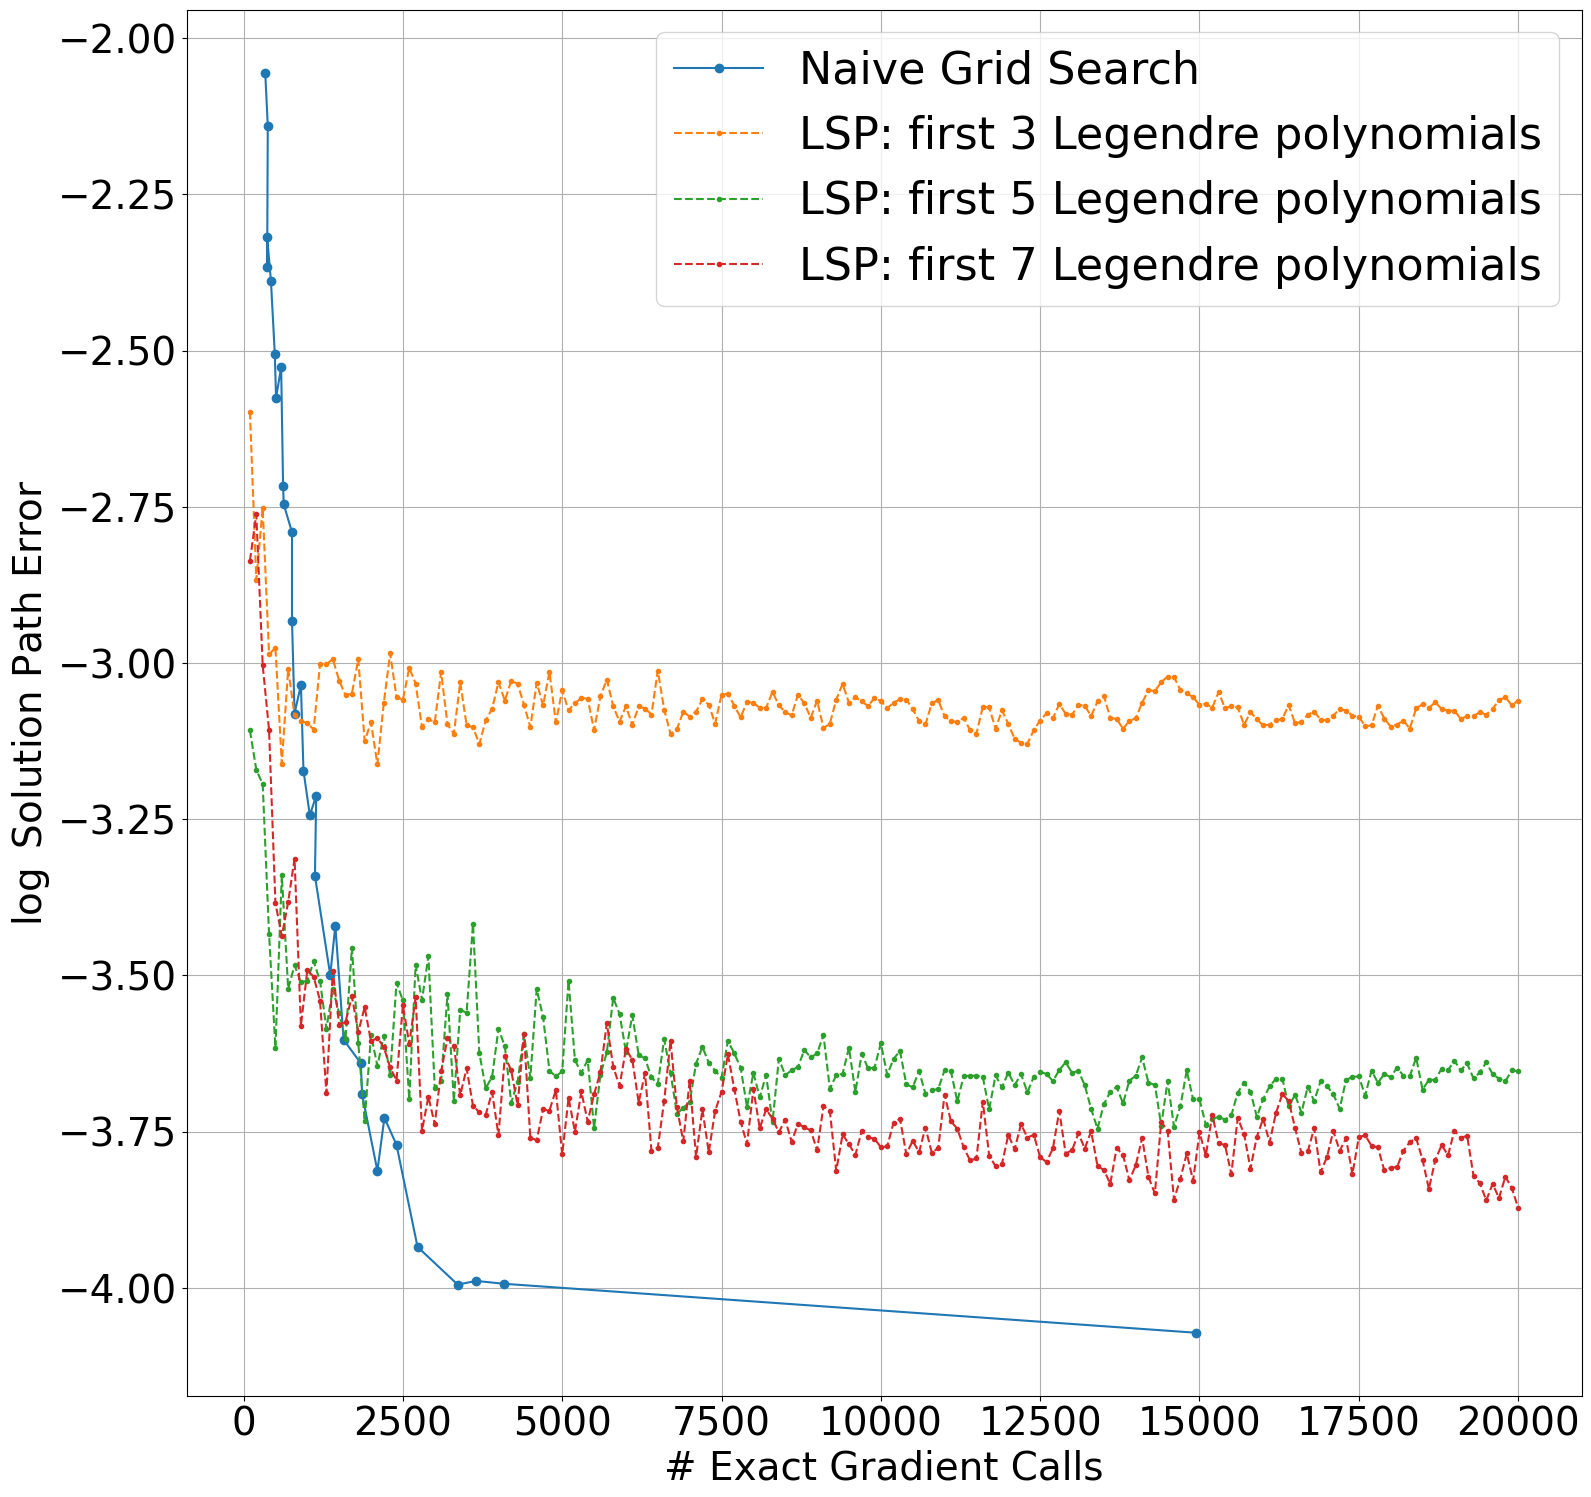

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,18))
plt.plot(num_itr_NGS[:len(num_itr_NGS)-1], np.log(sup_err_NGS[:len(num_itr_NGS)-1]), '-o', label = "Naive Grid Search")
plt.plot(num_itr_SGD[1::2], np.log(sup_err_SGD_3[1::2]), '--.', label = "LSP: first 3 Legendre polynomials")
plt.plot(num_itr_SGD[1::2], np.log(sup_err_SGD_5[1::2]), '--.', label = "LSP: first 5 Legendre polynomials")
plt.plot(num_itr_SGD[1::2], np.log(sup_err_SGD_7[1::2]), '--.', label = "LSP: first 7 Legendre polynomials")

# Set global font size
mpl.rcParams['font.size'] = 32

font_size = 28
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

plt.xlabel('# Exact Gradient Calls', fontsize=font_size)
plt.ylabel('$\\log$ Solution Path Error', fontsize=font_size)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# save figure
plt.savefig("itr_noisy.png")

# Mini-experiments

In [ ]:
lam_max = 1
lam_min = 0
alpha = 2**3
max_epochs = 5000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** np.arange(2.875, 3.5, 0.125)

In [ ]:
total_itr_list = []
sup_error_list = []
np.random.seed(8675309)
torch.manual_seed(8675309)
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = round(1 / np.sqrt(delta))

    start_time = time.time()
    total_itr, reg_params, intercepts, weights = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                trainDataLoader=SGD_data_loader, data_input_dim=input_dim, obj='fairness',
                                alpha=alpha, init_lr=1, SGD=True, testDataLoader=test_data_loader,
                                true_loss_list=true_losses, stopping_criterion=delta)

    end_time = time.time()
    execution_time = end_time - start_time

    total_itr_list.append(total_itr)

    sup_error = NGS.get_sup_error(lam_min, lam_max, true_losses, intercepts,
                                  weights, reg_params, test_data_loader, criterion, obj='fairness')

    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")

total_itr_list = np.array(total_itr_list)
sup_error_list = np.array(sup_error_list)

grid #: 271	 total iteration #: 7570	 sup error: 0.13786832243204122	 Execution time: 2667.2783904075623 seconds
grid #: 283	 total iteration #: 14160	 sup error: 0.15650933980941772	 Execution time: 4945.324548244476 seconds
grid #: 295	 total iteration #: 25110	 sup error: 0.15305238962173467	 Execution time: 8794.508772611618 seconds


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Experiments')

import NGS_old

import importlib
importlib.reload(NGS_old)

Using device: cpu


<module 'NGS_old' from '/content/drive/MyDrive/Experiments/NGS_old.py'>

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Experiments')

import NGS

import importlib
importlib.reload(NGS)

Using device: cpu


<module 'NGS' from '/content/drive/MyDrive/Experiments/NGS.py'>

In [ ]:
delta = 0.5**6
num_grid = round(1 / np.sqrt(delta))

models, total_itr = NGS_old.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                    num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                    trainDataLoader=SGD_data_loader,
                                    data_input_dim=input_dim,
                                    alpha=alpha, SGD=True, testDataLoader=test_data_loader,
                                    true_loss_list=true_losses, stopping_criterion=delta)

sup_error = NGS_old.get_sup_error(lam_min, lam_max, true_losses, models, test_data_loader, criterion)


print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")


tensor(0.1000) 0.0 0.0
tensor(0.1000) 0.0004754960536956787 0.0830620750784874
tensor(0.1000) 0.0015659779310227273 0.1440490633249282
tensor(0.1000) 0.0017708986997604925 0.1885033398866653
tensor(0.1000) 0.004509747028350886 0.2171219885349273
tensor(0.1000) 0.0015344917774201272 0.2265795171260833
tensor(0.1000) 0.0026634633541107178 0.2067854404449463
tensor(0.1000) 0.011623900383710924 0.0473512597382068
grid #: 8	 total iteration #: 80	 sup error: 0.2766956686973572	 Execution time: 22.608722448349 seconds


In [ ]:
delta = 0.5**6
num_grid = round(1 / np.sqrt(delta))

total_itr, reg_params, intercepts, weights = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                trainDataLoader=SGD_data_loader,
                                data_input_dim=input_dim,
                                alpha=alpha, SGD=True, testDataLoader=test_data_loader,
                                true_loss_list=true_losses, stopping_criterion=delta)

sup_error = NGS.get_sup_error(lam_min, lam_max, true_losses, intercepts,
                                  weights, reg_params, test_data_loader, criterion)

print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}")

grid #: 8	 total iteration #: 80	 sup error: 0.2733657956123352


In [ ]:
csv_file_path = '/content/drive/MyDrive/Experiments/exact_soln_list_new.csv'
truth = pd.read_csv(csv_file_path)
selected_columns = ['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4',
                    'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9',
                    'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14',
                    'theta_15', 'theta_16', 'theta_17', 'theta_18', 'theta_19',
                    'theta_20', 'theta_21', 'theta_22', 'theta_23', 'theta_24',
                    'theta_25', 'theta_26', 'theta_27', 'theta_28', 'theta_29',
                    'theta_30']
true_thetas = truth[selected_columns].to_numpy()
true_losses = truth['losses'].to_numpy()

In [ ]:
full_data = helpers.Regression_Data(X, y)
# full gradient descent uses all data points
GD_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(full_data, batch_size=5, shuffle=True, )
# test data
test_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=False, )

In [ ]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]
criterion=torch.nn.BCELoss()
lr = 0.5**4
max_epochs = 5000
# a list of solution accuracy delta wish to be achieved
# delta_list = 0.5 ** np.arange(14.4, 15.5, 0.1)
delta_list = 0.5 ** np.arange(14, 16, 0.5)

In [ ]:
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = round(1 / np.sqrt(delta))

    total_itr, reg_params, intercepts, weights = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                trainDataLoader=GD_data_loader,
                                data_input_dim=input_dim,
                                lr=lr, SGD=False, testDataLoader=test_data_loader,
                                true_loss_list=true_losses, stopping_criterion=delta)

    sup_error = NGS.get_sup_error(lam_min, lam_max, true_losses, intercepts,
                                  weights, reg_params, test_data_loader, criterion)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}")

grid #: 128	 total iteration #: 10860	 sup error: 0.006182953715324485
grid #: 152	 total iteration #: 12420	 sup error: 0.00640395283699044
grid #: 181	 total iteration #: 14550	 sup error: 0.0028495825827121735
grid #: 215	 total iteration #: 17280	 sup error: 0.0027718245983124334


In [ ]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]
criterion=torch.nn.BCELoss()
lr = 0.5**4
max_epochs = 5000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** torch.arange(14, 16, 0.5)
# print(delta_list)

In [ ]:
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = torch.round(1 / torch.sqrt(delta))

    models, total_itr = NGS_old.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                    num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                    trainDataLoader=GD_data_loader,
                                    data_input_dim=input_dim,
                                    lr=lr, SGD=False, testDataLoader=test_data_loader,
                                    true_loss_list=true_losses, stopping_criterion=delta)

    sup_error = NGS_old.get_sup_error(lam_min, lam_max, true_losses, models, test_data_loader, criterion)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}")

grid #: 128.0	 total iteration #: 10870	 sup error: 0.006182946264743888
grid #: 152.0	 total iteration #: 12500	 sup error: 0.006403744220733726
grid #: 181.0	 total iteration #: 14580	 sup error: 0.002849586308002472
grid #: 215.0	 total iteration #: 21800	 sup error: 0.0027718245983124334


In [ ]:
num_grid = 2**10+1
fine_delta_lam = (lam_max - lam_min)/num_grid
lambdas = np.linspace(lam_max, lam_min, num_grid)

In [ ]:
delta  = torch.tensor(0.5 ** 14.5)

num_grid = torch.round(1 / torch.sqrt(delta))

models, total_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                    num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                    trainDataLoader=GD_data_loader,
                                    data_input_dim=input_dim,
                                    lr=lr, SGD=False, testDataLoader=test_data_loader,
                                    true_loss_list=true_losses, stopping_criterion=delta)

In [ ]:
NGS.get_sup_error(lam_min, lam_max, true_losses, models, test_data_loader, criterion)

i = 1016	 lam = 0.0078125	 nearest grid = 151	 nearest lam = 0.0068359375	 sup error = 0.0007901489734650491
i = 1017	 lam = 0.0068359375	 nearest grid = 151	 nearest lam = 0.0068359375	 sup error = 0.0007901489734650491
i = 1018	 lam = 0.005859375	 nearest grid = 151	 nearest lam = 0.0068359375	 sup error = 0.0007901489734650491
i = 1019	 lam = 0.0048828125	 nearest grid = 151	 nearest lam = 0.0068359375	 sup error = 0.0008999258279800693
i = 1020	 lam = 0.00390625	 nearest grid = 151	 nearest lam = 0.0068359375	 sup error = 0.001976937055587852
i = 1021	 lam = 0.0029296875	 nearest grid = 152	 nearest lam = 0.0	 sup error = 0.006403744220733726
i = 1022	 lam = 0.001953125	 nearest grid = 152	 nearest lam = 0.0	 sup error = 0.006403744220733726
i = 1023	 lam = 0.0009765625	 nearest grid = 152	 nearest lam = 0.0	 sup error = 0.006403744220733726
i = 1024	 lam = 0.0	 nearest grid = 152	 nearest lam = 0.0	 sup error = 0.006403744220733726


0.006403744220733726

In [ ]:
delta  = torch.tensor(0.5 ** 14.6)

num_grid = torch.round(1 / torch.sqrt(delta))

models, total_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                    num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                    trainDataLoader=GD_data_loader,
                                    data_input_dim=input_dim,
                                    lr=lr, SGD=False, testDataLoader=test_data_loader,
                                    true_loss_list=true_losses, stopping_criterion=delta)

In [ ]:
NGS.get_sup_error(lam_min, lam_max, true_losses, models, test_data_loader, criterion)

i = 1016	 lam = 0.0078125	 nearest grid = 157	 nearest lam = 0.005859375	 sup error = 0.0010013505816460072
i = 1017	 lam = 0.0068359375	 nearest grid = 157	 nearest lam = 0.005859375	 sup error = 0.0010013505816460072
i = 1018	 lam = 0.005859375	 nearest grid = 157	 nearest lam = 0.005859375	 sup error = 0.0010013505816460072
i = 1019	 lam = 0.0048828125	 nearest grid = 157	 nearest lam = 0.005859375	 sup error = 0.0010013505816460072
i = 1020	 lam = 0.00390625	 nearest grid = 157	 nearest lam = 0.005859375	 sup error = 0.001108832657337272
i = 1021	 lam = 0.0029296875	 nearest grid = 157	 nearest lam = 0.005859375	 sup error = 0.002541512250900352
i = 1022	 lam = 0.001953125	 nearest grid = 158	 nearest lam = 0.0	 sup error = 0.0025872588157654364
i = 1023	 lam = 0.0009765625	 nearest grid = 158	 nearest lam = 0.0	 sup error = 0.0025872588157654364
i = 1024	 lam = 0.0	 nearest grid = 158	 nearest lam = 0.0	 sup error = 0.0028724446892738342


0.0028724446892738342

In [ ]:
errs = np.array(NGS.get_errs(lam_min, lam_max, true_losses, models, test_data_loader, criterion))

In [ ]:
errs[1015:1025]

array([6.30319118e-05, 6.02230430e-05, 2.86646187e-04, 7.94149935e-04,
       1.65752321e-03, 2.99172103e-03, 6.35817647e-03, 2.43765861e-03,
       4.31183726e-04, 3.07774171e-03])

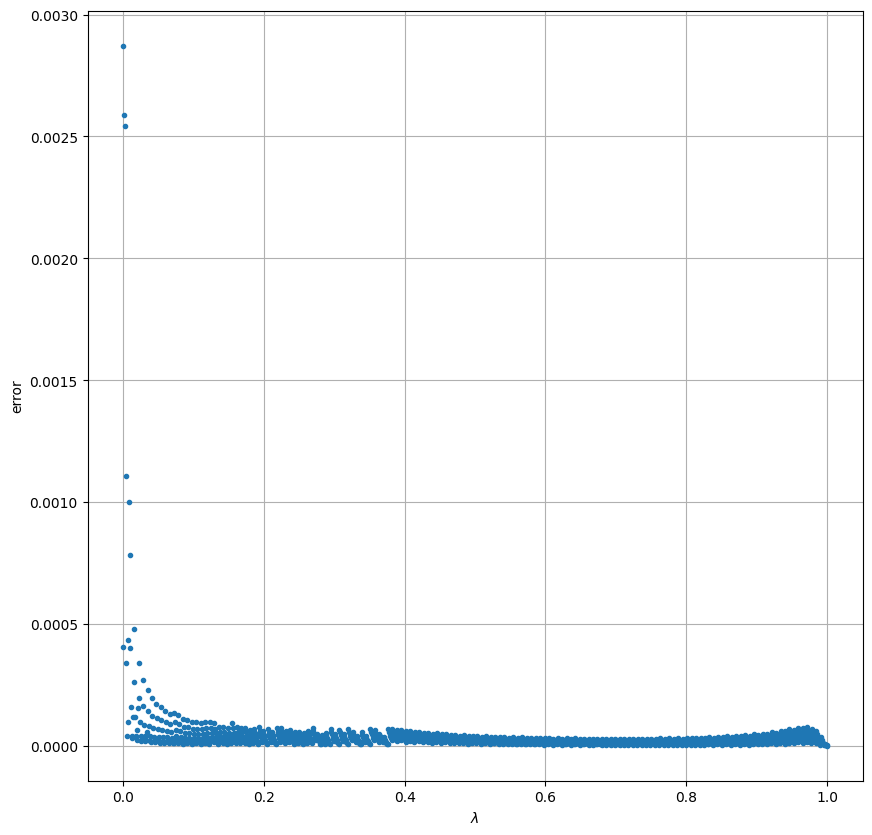

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(lambdas, errs, '.')
plt.ylabel('error')
plt.xlabel('$\\lambda$')
plt.grid(True)

In [ ]:
delta  = torch.tensor(0.5 ** 14.5)

num_grid = torch.round(1 / torch.sqrt(delta))

models, total_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                trainDataLoader=GD_data_loader,
                                data_input_dim=input_dim,
                                lr=lr, SGD=False, testDataLoader=test_data_loader,
                                true_loss_list=true_losses, stopping_criterion=delta)

errs = np.array(NGS.get_errs(lam_min, lam_max, true_losses, models, test_data_loader, criterion))

In [ ]:
errs[1015:1025]

array([3.40797007e-04, 7.72327185e-05, 4.29078937e-05, 2.89656222e-04,
       8.92281532e-04, 1.96572393e-03, 6.58701360e-03, 2.54034251e-03,
       4.07706946e-04, 2.92810425e-03])

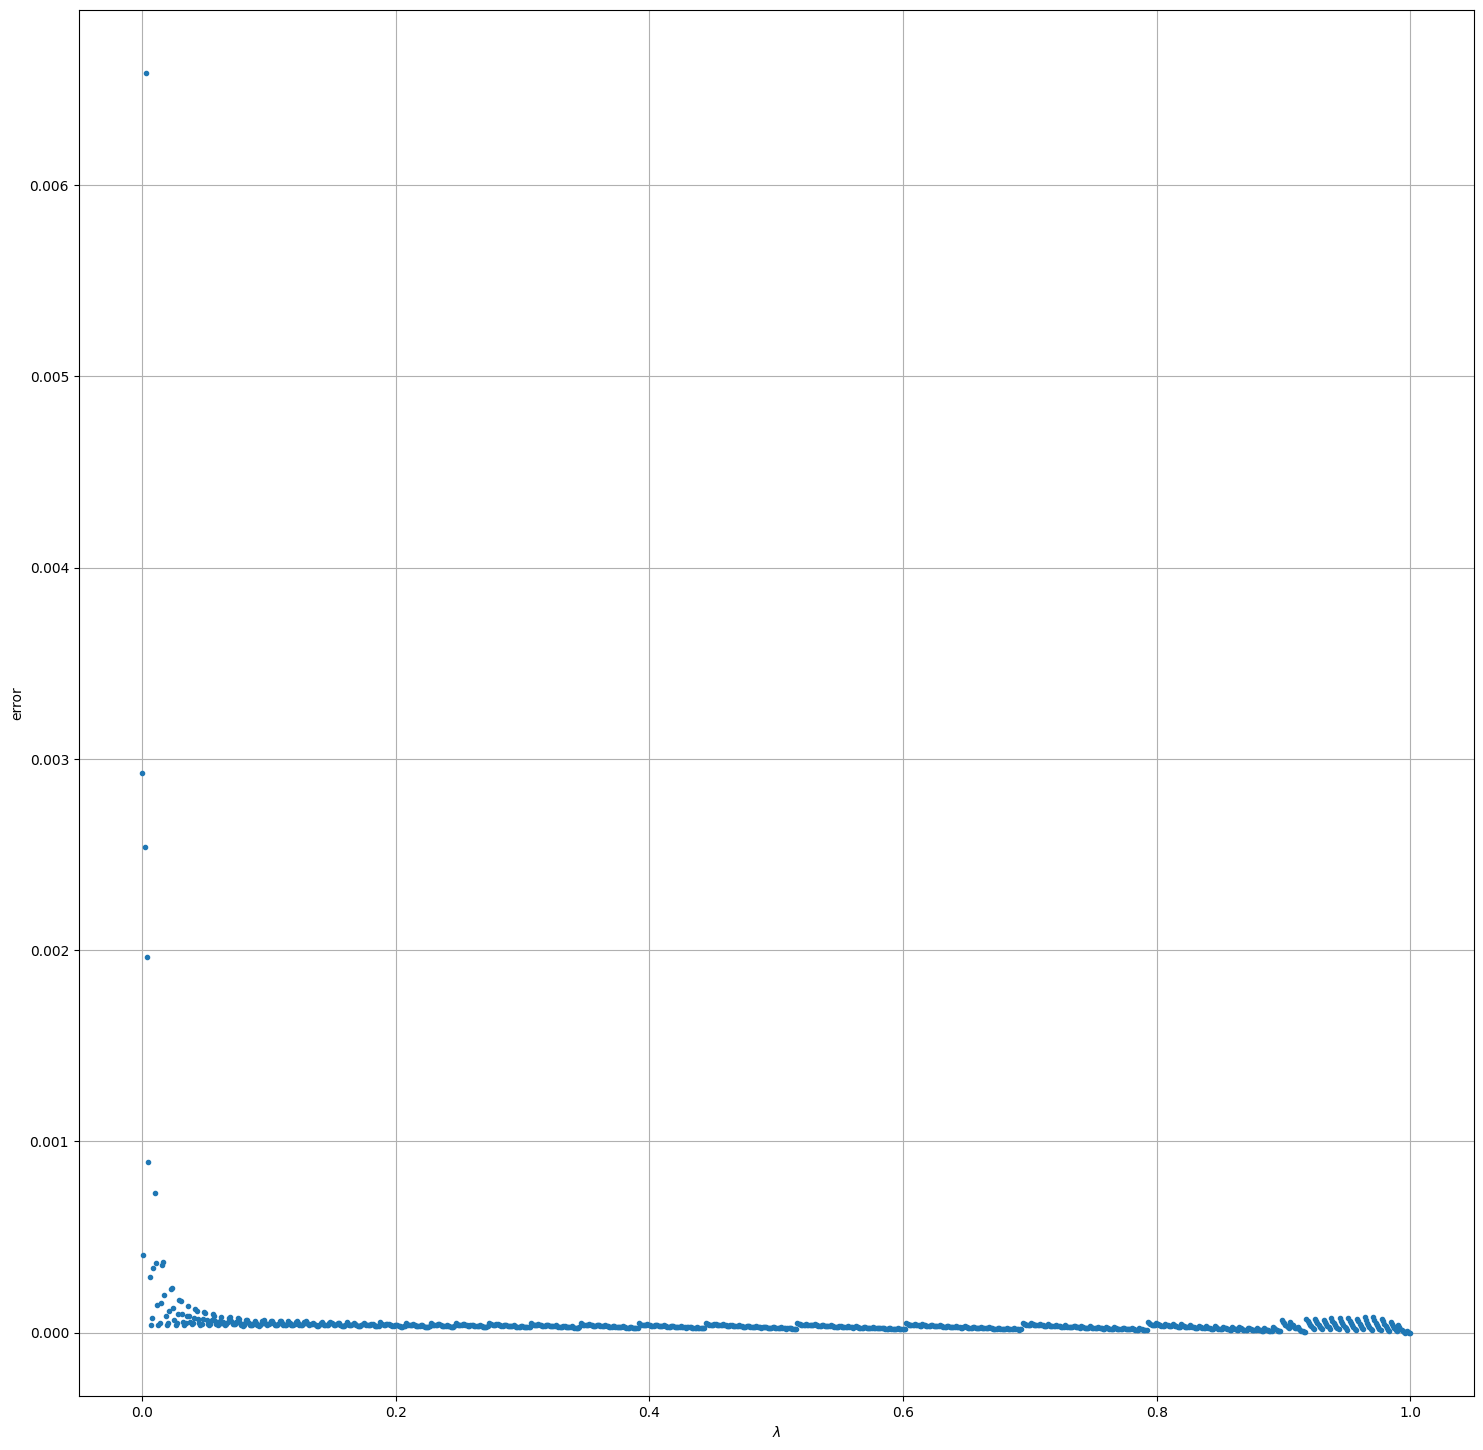

In [ ]:
plt.figure(figsize=(18,18))
plt.plot(lambdas, errs, '.')
plt.ylabel('error')
plt.xlabel('$\\lambda$')
plt.grid(True)

In [ ]:
delta  = torch.tensor(0.5 ** 15)

num_grid = torch.round(1 / torch.sqrt(delta))

models, total_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                trainDataLoader=GD_data_loader,
                                data_input_dim=input_dim,
                                lr=lr, SGD=False, testDataLoader=test_data_loader,
                                true_loss_list=true_losses, stopping_criterion=delta)

errs = np.array(NGS.get_errs(lam_min, lam_max, true_losses, models, test_data_loader, criterion))

In [ ]:
errs[1015:1025]

array([4.25755978e-04, 4.58098948e-04, 1.03600323e-04, 3.01748514e-05,
       3.12633812e-04, 1.06590241e-03, 2.48350948e-03, 2.67407298e-03,
       3.83257866e-04, 2.74547935e-03])

In [ ]:
models[len(models)-1].reg_param

tensor(0.)

In [ ]:
lam_max - 1021 * fine_delta_lam

0.0029296875

In [ ]:
delta  = torch.tensor(0.5 ** 15.5)

num_grid = torch.round(1 / torch.sqrt(delta))

models, total_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                trainDataLoader=GD_data_loader,
                                data_input_dim=input_dim,
                                lr=lr, SGD=False, testDataLoader=test_data_loader,
                                true_loss_list=true_losses, stopping_criterion=delta)

errs = np.array(NGS.get_errs(lam_min, lam_max, true_losses, models, test_data_loader, criterion))

In [ ]:
errs[1015:1025]

array([1.39594078e-04, 4.49456275e-04, 6.30043447e-04, 1.47841871e-04,
       2.15247273e-05, 3.66024673e-04, 1.37485564e-03, 2.85854191e-03,
       3.58358026e-04, 2.51120701e-03])

In [ ]:
weight = true_thetas[1023]

In [ ]:
model = NGS.Logistic_Regression(input_dim, 1, lam_min, torch.zeros(input_dim)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
with torch.no_grad():
      model.linear.weight.copy_(torch.tensor(weight[1:31]))
      model.linear.bias.data.fill_(weight[0])

for t in range(epochs):
      NGS.train(GD_data_loader, model, criterion, optimizer, trace_frequency=5)

In [ ]:
intercept = model.linear.bias.data.cpu().detach().numpy()[0]
theta = model.linear.weight.data.cpu().detach().numpy()[0]
loss = NGS.test(test_data_loader, model, criterion, model.reg_param)

In [ ]:
loss, intercept, theta

(0.047288715839385986,
 -0.015424374,
 array([-0.30815375, -0.33608237, -0.28979003, -0.4639725 , -0.17569996,
         0.9534354 , -1.1510415 , -1.3006877 ,  0.20398842,  0.351857  ,
        -1.8399656 ,  0.40856507, -0.87782896, -1.4572122 , -0.40147662,
         1.0259336 ,  0.15781668, -0.44512102,  0.39260328,  0.9443559 ,
        -1.362588  , -1.8173596 , -1.0457896 , -1.3904444 , -0.8421279 ,
         0.14110662, -1.1808962 , -1.2162    , -1.1959442 , -0.7288902 ],
       dtype=float32))

In [ ]:
import csv
# Open the CSV file in append mode and write the new row
with open("/content/drive/MyDrive/Experiments/exact_soln_list.csv", 'a', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow([loss, intercept, theta[0], theta[1],
                             theta[2], theta[3], theta[4], theta[5],
                             theta[6], theta[7], theta[8], theta[9],
                             theta[10], theta[11], theta[12], theta[13],
                             theta[14], theta[15], theta[16], theta[17],
                             theta[18], theta[19], theta[20], theta[21],
                             theta[22], theta[23], theta[24], theta[25],
                             theta[26], theta[27], theta[28], theta[29]])